# Import packages

In [1]:
from array import array
import itertools
import time
import math

import sys
#####For NERSC:####
#sys.path.insert(0,'/usr/common/software/rootpy/')
import root_numpy
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

#import astroML.plotting as aml
#import iminuit
import pandas as pd
import root_pandas as rpd
from root_pandas import read_root
import ROOT
from ROOT import TH1D
from ROOT import SetOwnership
from matplotlib.ticker import NullFormatter
from ROOT import TLatex
%matplotlib inline                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

Welcome to JupyROOT 6.14/04


# Files and Purity

In [2]:
HighpT = False
Shower = "NN"
#Shower = "LO"
CorrectedP = False     #FALSE FOR HARDPROBES

if (Shower == "NN"):
    
    if not(HighpT):
        pPb_File = 'InputData/13def_SE_GMB_new_Ratio.root'
        pp_File = 'InputData/17q_SE_NN_Correlation_GMB_Ratio.root'
        if (CorrectedP):
            purity = 0.2615
        else:
            purity = 0.352546
            
    if(HighpT):
        pp_File = "InputData/17q_SE_NN_Correlatios_GMB_Ratio_HighpT.root"
        pPb_File = "InputData/13def_SE_NN_Correlatios_GMB_Ratio_HighpT.root"
        purity = 0.43
        
if (Shower == "LO"):
    pPb_File = 'InputData/13def_SE_L0_Correlation_GMB_Ratio.root'
    pp_File = 'InputData/17q_SE_L0_Correlation_GMB_Ratio.root'
    if (CorrectedP):
        purity = 0.221083
    else:
        purity = 0.271083
        
print purity

MC_File = 'InputData/18b10a_pthat_1_2_SE_NN_Correlation_GMB_Ratio.root'

Use_MC = True

if(Use_MC):
    Systems = ["pp","p-Pb","MC"]
    Files = [pp_File,pPb_File,MC_File]
    
else:
    Systems = ["pp","p-Pb"]
    Files = [pp_File,pPb_File]


#pPb_File = 'InputData/13def_EMax_SE_GMB_Ratio.root'
#pp_File = 'InputData/17q_SE_EMax_Correlation_GMB_Ratio.root'


0.352546


# Define Bins


In [3]:
#delta_phi_centers= np.array([0.19634954084936207, 0.5890486225480862, 0.9817477042468103, 1.3744467859455345, 1.7671458676442586, 2.1598449493429825, 2.552544031041707, 2.945243112740431])

####Ommiting first dphi bin######
delta_phi_centers= np.array([0.5890486225480862, 0.9817477042468103, 1.3744467859455345, 1.7671458676442586, 2.1598449493429825, 2.552544031041707, 2.945243112740431])
phi_width = [0.39269908169872414/2]*len(delta_phi_centers)

###Array used for UE Error bar####
ue_error_bar = np.array([0,0.05,0.1,0.15,0.2,0.25,0.3,0.39269908169872414,2*0.39269908169872414])

zTbins = [0.05, 0.07670637, 0.11767734, 0.18053204, 0.27695915, 0.42489062, 0.65183634, 1]

if(HighpT):
    pTbins = [0,0,15,20]
    
else:
    pTbins = [0,0,12, 15]
    
#####. Total Number of zT bins, max 7  #####
NzT = 4

#####  Skip First N zT bins  #####
zT_offset = 2

zT_centers = np.zeros(NzT)
zT_widths = np.zeros(NzT)
for ztbin in range(zT_offset,NzT+zT_offset):
    zT_centers[ztbin-zT_offset] = (zTbins[ztbin]+ zTbins[ztbin+1])/2
    zT_widths[ztbin-zT_offset] = (zTbins[ztbin+1]-zTbins[ztbin])/2

Corrections = [1,1.007,0.982,0.970,0.942,0.830,0.640]
oneminFake = [1,0.982,0.980,0.978,0.970,0.915,0.812]

## Max $\Delta \eta$ for signal

In [4]:
eta_max = 0.6

# Define Errors

In [5]:
p_error_sys = 0.06
p_error_stat = 0.028
eff_error = 0.05

# ZYAM

In [6]:
def ZYAM_Line(Phi_Array, Phi_Error_Array):
    
    z_temp = Phi_Array[2:3]
    Z_Value = z_temp.mean()
    
    z_temp_error = Phi_Error_Array[2:3]**2
    Z_Error = z_temp_error.sum()
    Z_Error = math.sqrt(Z_Error)
    Z_Error = Z_Error/len(z_temp_error)
    
    return Z_Value,Z_Error

# N Triggers

In [7]:
def Get_NTriggers(filename,ipt, Signal_DNN=True): 
    file = ROOT.TFile(filename)
    if (Signal_DNN == "Inclusive"):
        ntrig_histo = file.Get('N_Triggers_pT%1.0f_%1.0f' %(pTbins[ipt],pTbins[ipt+1]))
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN))
        ntrig_histo = file.Get('N_DNN%i_Triggers_pT%1.0f_%1.0f' %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1]))
    NTriggers = 1
    if not(ntrig_histo == None):
        NTriggers = ntrig_histo.GetEntries()
    file.Close()
    return NTriggers

# Large $\eta$

In [8]:
def GetLEProj(filename, ipt, izt, Signal_DNN=True,DoAverage=True):
    file = ROOT.TFile(filename)
    
    if (Signal_DNN == "Inclusive"):
        histo2D = file.Get('Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                        %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        
        LE_Projection = histo2D.ProjectionX('Inclusive_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1]),Eta_Axis.FindBin(-1.4),Eta_Axis.FindBin(-0.8))
                                        #10*zTbins[izt+1]),5,11)
        LE_Projection_pos = histo2D.ProjectionX('PosEta_inclusive_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                    100*zTbins[izt+1]),Eta_Axis.FindBin(0.8),Eta_Axis.FindBin(1.4))
  
        ntriggers = Get_NTriggers(filename, ipt, Signal_DNN)  
        if not(ntriggers == None):
            LE_Projection.Scale(1.0/ntriggers) #per trigger yield
            LE_Projection_pos.Scale(1.0/ntriggers)
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)

        if (DoAverage):
            histo2D_1 = file.Get('DNN1_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                                 %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))

            histo2D_2 = file.Get('DNN2_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                                 %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        else:
            histo2D_1 = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                            %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))

            histo2D_2 = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                            %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        #Project
        Eta_Axis = histo2D_1.GetYaxis()
  
        ntriggers_DNN2 = Get_NTriggers(filename, ipt, False) 
        
        if (DoAverage):
            ntriggers_DNN1 = Get_NTriggers(filename, ipt, True) 
        else:
            ntriggers_DNN1 = Get_NTriggers(filename, ipt, Signal_DNN)   
    
        LE_Projection = histo2D_1.ProjectionX('NegEta_DNN1_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(-1.4),Eta_Axis.FindBin(-0.8))
        
        LE_Projection_pos = histo2D_1.ProjectionX('PosEta_DNN1_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(0.8),Eta_Axis.FindBin(1.4))    
        
        LE_Projection_DNN2 = histo2D_2.ProjectionX('NegEta2_DNN2_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(-1.4),Eta_Axis.FindBin(-0.8))

        LE_Projection_DNN2_pos = histo2D_2.ProjectionX('PosEta2_DNN2_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(0.8),Eta_Axis.FindBin(1.4))
        
        LE_Projection.Scale(1.0/ntriggers_DNN1)
        LE_Projection_pos.Scale(1.0/ntriggers_DNN1)
        
        LE_Projection_DNN2.Scale(1.0/ntriggers_DNN2)
        LE_Projection_DNN2_pos.Scale(1.0/ntriggers_DNN2)
        
        if (DoAverage):
            LE_Projection.Add(LE_Projection_DNN2,1.0)
            LE_Projection.Scale(0.5)
        
            LE_Projection_pos.Add(LE_Projection_DNN2_pos,1.0)
            LE_Projection_pos.Scale(0.5)
        
    
    #Add,scale 
    LE_Projection.SetDirectory(0)
    LE_Projection.Add(LE_Projection_pos,1)
    LE_Projection.Rebin(2)
    LE_Projection.Scale(1.0/1.2) #scale by eta region
    
    file.Close()
    
    LE_Phi_Array = np.zeros(len(delta_phi_centers))
    LE_Error_Array = np.zeros(len(delta_phi_centers))
    for bin in range(2,9):
                LE_Phi_Array[bin-2] = LE_Projection.GetBinContent(bin)
                LE_Error_Array[bin-2] = LE_Projection.GetBinError(bin)
    
    return LE_Phi_Array, LE_Error_Array

In [9]:
def GetLE_Val( LE_Phi_Array, LE_Error_Array):
    LE_temp = LE_Phi_Array[:3]
    LE_value = LE_temp.mean()
    
    LE_temp_error = LE_Error_Array[:3]**2
    LE_Error = LE_temp_error.sum()
    LE_Error = math.sqrt(LE_Error)
    LE_Error = LE_Error/len(LE_temp_error)
    
    return LE_value, LE_Error

<sup>The DNN corresponding to one photon is reflected in the naming scheme of histograms, where DNN1_Histo is signal (the same here) but background (DNN corresponding to 2 photons) is DNN2_Histo. Here, the DNN variable is a boolian corresponding to *true for signal*, *false for background* (not signal)<sup>

# Get Phi Projection

In [10]:
#####Obtains the phi projection within the eta region (|eta|<0.6)#####
def GetPhiProj(filename,prfx,ipt, izt, Signal_DNN=True):
    
    file = ROOT.TFile(filename)
    
    if (Signal_DNN == "Inclusive"):
        histo2D = file.Get('Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                        %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        PhiProjection = histo2D.ProjectionX('Inclusive_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1]),Eta_Axis.FindBin(-eta_max),Eta_Axis.FindBin(eta_max))
    
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
        histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                            %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        PhiProjection = histo2D.ProjectionX('DNN%i_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1]),Eta_Axis.FindBin(-eta_max),Eta_Axis.FindBin(eta_max))
                                            
    PhiProjection.SetDirectory(0)
    PhiProjection.Rebin(2)
    PhiProjection.Scale(1.0/(2*eta_max))
    
    #per trigger yield
    ntriggers = Get_NTriggers(filename,ipt, Signal_DNN)
    if not(ntriggers == None):
        PhiProjection.Scale(1.0/ntriggers)
    
    file.Close()
    
    Phi_Array = np.zeros(len(delta_phi_centers))
    Phi_Error_Array = np.zeros(len(delta_phi_centers))
    for bin in range(2,9):
        Phi_Array[bin-2] = PhiProjection.GetBinContent(bin)
        Phi_Error_Array[bin-2] = PhiProjection.GetBinError(bin)
    
    return Phi_Array, Phi_Error_Array

<sup>SetDirectory(0) needed because when a file in root is called, the gDirectory is changed to point to it. The creation of a histogram (PhiProjection) is associated to that file and contains a local reference, which is destroyed when the function exits. Thus, returns 'None' unless the Directory (reference) is changed. Root is annoying.</sup>

# Inclusive UE

In [11]:
# Systems = ["pp","p-Pb"]
# Files = [pp_File,pPb_File]

# for sys,ifile in zip(Systems,Files):
#     print(" $z_T$ interval   & LE Signal Region & LE Background Region & ZYAM Signal Region & ZYAM Background Region")
#     fig = plt.figure(figsize=(34,8))
#     for ipt in range (3):
#         if (ipt > 0): continue
#         ipt = ipt+2
#         for izt in range (2,6):
#             ztb = izt-2
#             Sig_LE_Phi_Array, Sig_LE_Error_Array = GetLEProj(ifile, ipt, izt, "Inclusive",False)

#             S_LE, S_LE_Error = GetLE_Val(Sig_LE_Phi_Array, Sig_LE_Error_Array)

#             Sig_Phi_Array, Sig_Phi_Error_Array = GetPhiProj(ifile,sys,ipt,izt,"Inclusive")


#             Sig_Z_Value,Sig_Z_Error = ZYAM_Line(Sig_Phi_Array, Sig_Phi_Error_Array)


#             print("%1.2f - %1.2f & %1.3f $\pm$ %1.3f & %1.3f $\pm$ %1.3f \\\\"
#                   %(zTbins[izt],zTbins[izt+1],S_LE,S_LE_Error,Sig_Z_Value,Sig_Z_Error))

                                            
#                                         #--------------plot--------------------#
           
        
#             ax = fig.add_subplot(1,4,(ztb+1))
#             fsize = 20

#             #sig
#             ax.plot(delta_phi_centers,Sig_Phi_Array,'bo',color="purple",ms=10)
#             s_plot = ax.errorbar(delta_phi_centers,Sig_Phi_Array,xerr=phi_width,yerr=Sig_Phi_Error_Array,fmt=None,ecolor='purple',label='Signal Region (stat. error)')

#             ax.plot(delta_phi_centers,Sig_LE_Phi_Array,'s',color="Grey",alpha=0.6,ms=10)
#             s_le_plot = ax.errorbar(delta_phi_centers,Sig_LE_Phi_Array,xerr=phi_width,yerr=Sig_LE_Error_Array,fmt=None,ecolor='Grey',alpha=0.8,label="0.8 <|$\Delta\eta$| < 1.4")

#             plt.xlabel(r'|$\Delta \varphi$|',fontsize=fsize+4)
#             plt.xticks(fontsize=(fsize))
#             plt.xlim((0.39269908169872414,3.14159))
#             plt.ylabel(r'$1/N_{\mathrm{trig}} \: \: \mathrm{d}N/\mathrm{d}\Delta\eta$',fontsize=fsize+2)
#             plt.ylim((0,1.2*max(Sig_LE_Phi_Array)))
#             empt, = ax.plot([], [], ' ')
#             empt2, = ax.plot([],[],' ')
#             plt.yticks(fontsize=fsize-5)

#             fill_x = [0,3.14149]
#             s_z_line = ax.fill_between(fill_x, Sig_Z_Value-Sig_Z_Error,Sig_Z_Value+Sig_Z_Error,interpolate=False,edgecolor='cyan',linewidth=0.0, alpha=0.3,facecolor='cyan')
#             s_le_line = ax.fill_between(fill_x, S_LE-S_LE_Error,S_LE+S_LE_Error,interpolate=False,edgecolor='grey',linewidth=0.0, alpha=0.5,facecolor='grey')

#             leg = ax.legend([s_plot,s_le_plot,s_le_line,s_z_line,empt,empt2],['Inclusive Clusters (stat. error)','0.8 <|$\Delta\eta$| < 1.4','UE Estimate',
#                 'ZYAM',r'%1.2f < $z_\mathrm{T}$ < %1.2f'%(zTbins[izt],zTbins[izt+1]),r'12 < $p_\mathrm{T}^{\mathrm{trig}}$ < 15 GeV/$c$'],
#                 loc='best',title = "Alice Preliminary %s 5 TeV",fontsize=14,frameon=False,numpoints=1)
#             if (sys == 'pp'):
#                 leg.set_title("ALICE Preliminary, $\sqrt{s}=$5 TeV %s"%(sys))
#             else:
#                 leg.set_title("ALICE Preliminary, $\sqrt{s_{\mathrm{_{NN}}}}=$5 TeV %s"%(sys))                
#             plt.setp(leg.get_title(),fontsize=14)

#             fig.savefig('pics/%s_Gamma_hadron_UE_zT_%i.pdf'%(sys,izt), bbox_inches='tight')        
#     print("")
#     #return



# UE Plot & Table

 $z_T$ interval   & LE Signal Region & LE Background Region & ZYAM Signal Region & ZYAM Background Region
0.12 - 0.18 & 0.061 $\pm$ 0.002 & 0.061 $\pm$ 0.002 & 0.067 $\pm$ 0.002 & 0.066 $\pm$ 0.0015 \\


/Users/fernando/Library/Python/2.7/lib/python/site-packages/matplotlib/axes/_axes.py:2818: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)


0.18 - 0.28 & 0.025 $\pm$ 0.001 & 0.023 $\pm$ 0.001 & 0.026 $\pm$ 0.001 & 0.025 $\pm$ 0.0009 \\
0.28 - 0.42 & 0.007 $\pm$ 0.001 & 0.008 $\pm$ 0.001 & 0.009 $\pm$ 0.001 & 0.009 $\pm$ 0.0006 \\
0.42 - 0.65 & 0.003 $\pm$ 0.001 & 0.005 $\pm$ 0.001 & 0.003 $\pm$ 0.001 & 0.004 $\pm$ 0.0005 \\

 $z_T$ interval   & LE Signal Region & LE Background Region & ZYAM Signal Region & ZYAM Background Region
0.12 - 0.18 & 0.166 $\pm$ 0.003 & 0.165 $\pm$ 0.002 & 0.163 $\pm$ 0.003 & 0.167 $\pm$ 0.0018 \\
0.18 - 0.28 & 0.060 $\pm$ 0.002 & 0.062 $\pm$ 0.001 & 0.062 $\pm$ 0.002 & 0.062 $\pm$ 0.0011 \\
0.28 - 0.42 & 0.016 $\pm$ 0.001 & 0.017 $\pm$ 0.001 & 0.018 $\pm$ 0.001 & 0.017 $\pm$ 0.0006 \\
0.42 - 0.65 & 0.004 $\pm$ 0.001 & 0.005 $\pm$ 0.000 & 0.003 $\pm$ 0.000 & 0.004 $\pm$ 0.0003 \\

 $z_T$ interval   & LE Signal Region & LE Background Region & ZYAM Signal Region & ZYAM Background Region
0.12 - 0.18 & 0.036 $\pm$ 0.003 & 0.048 $\pm$ 0.003 & 0.039 $\pm$ 0.003 & 0.045 $\pm$ 0.0026 \\
0.18 - 0.28 & 0.01

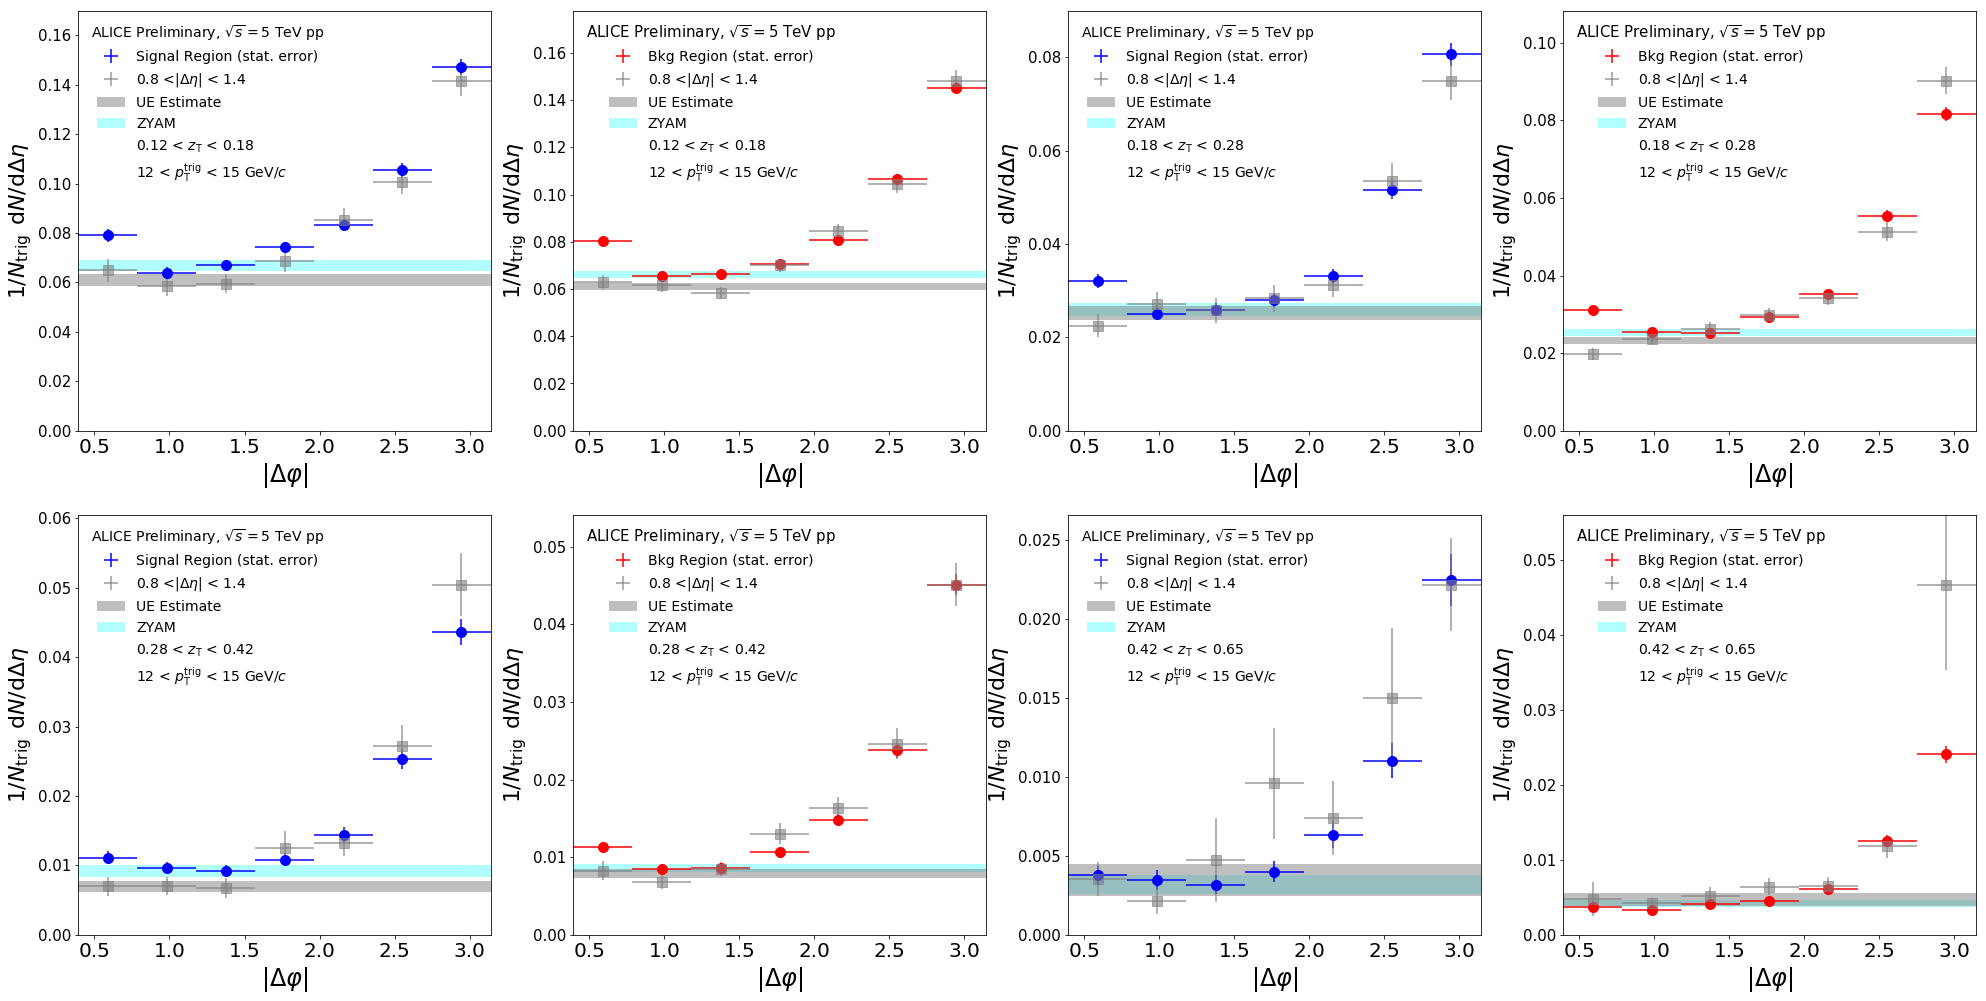

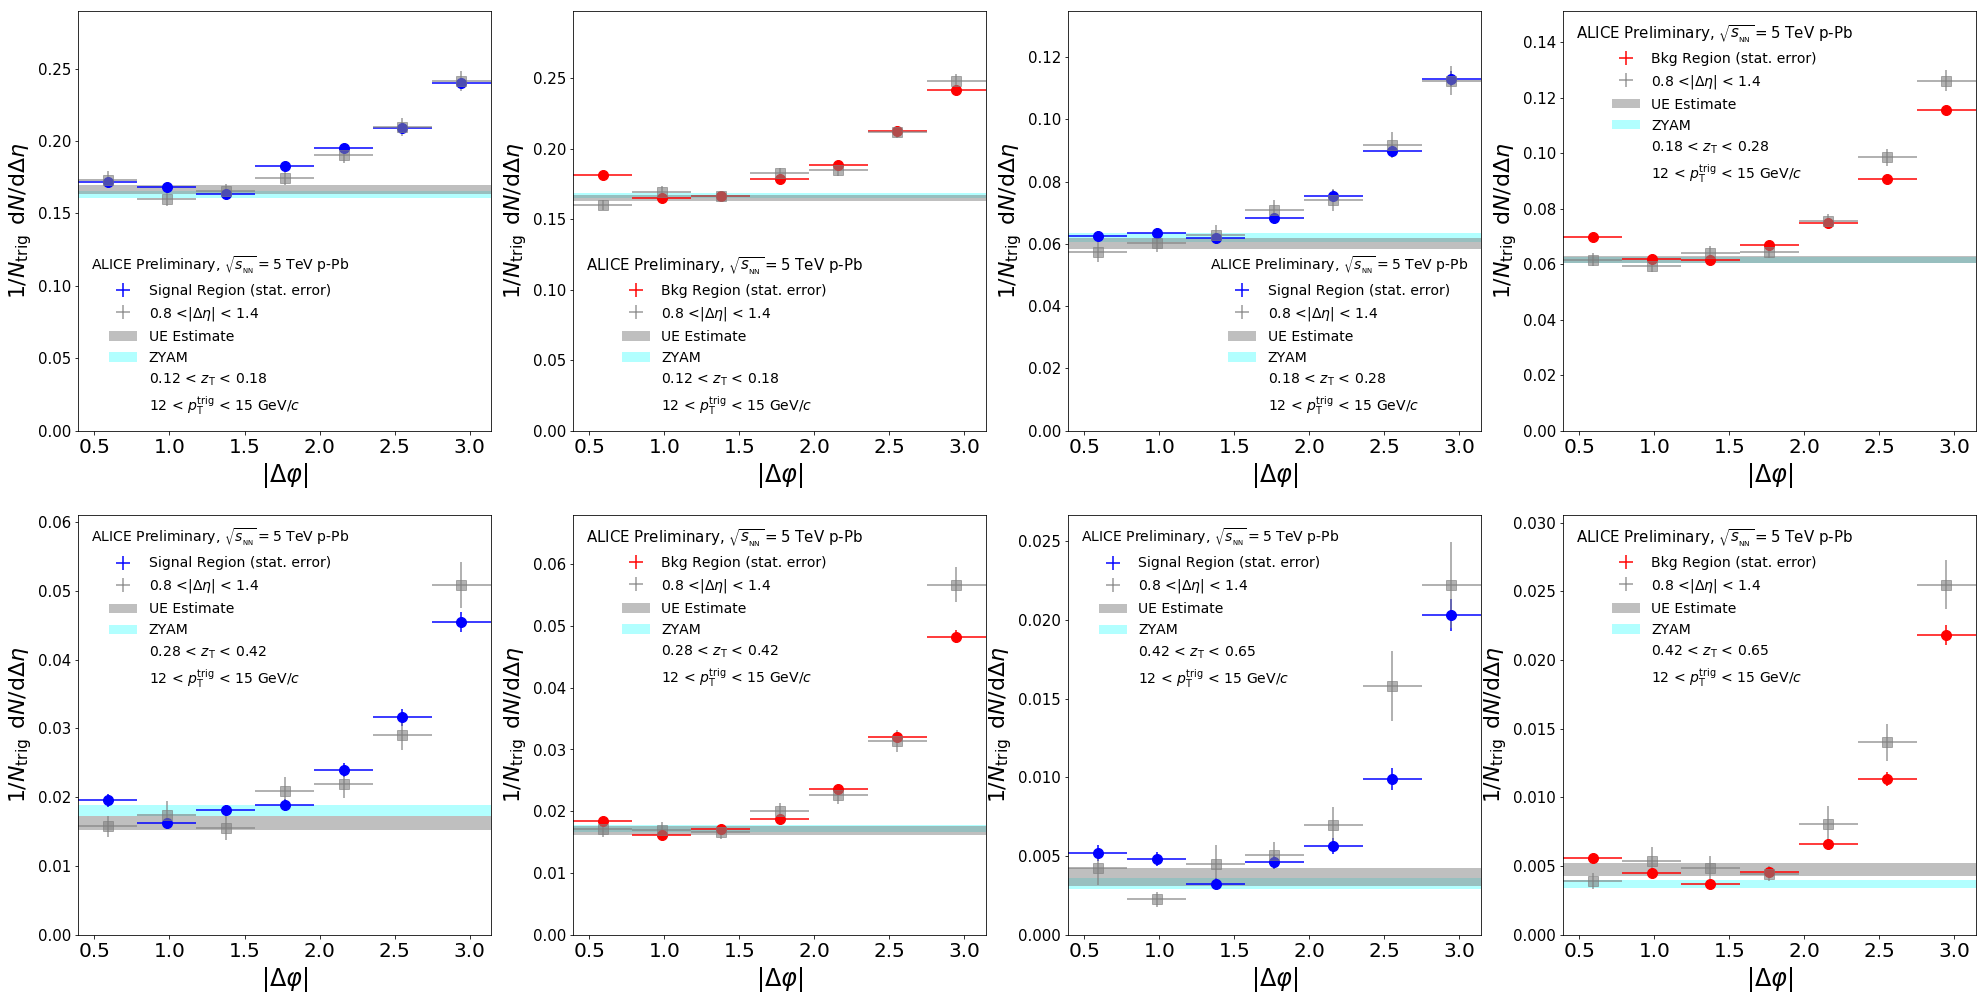

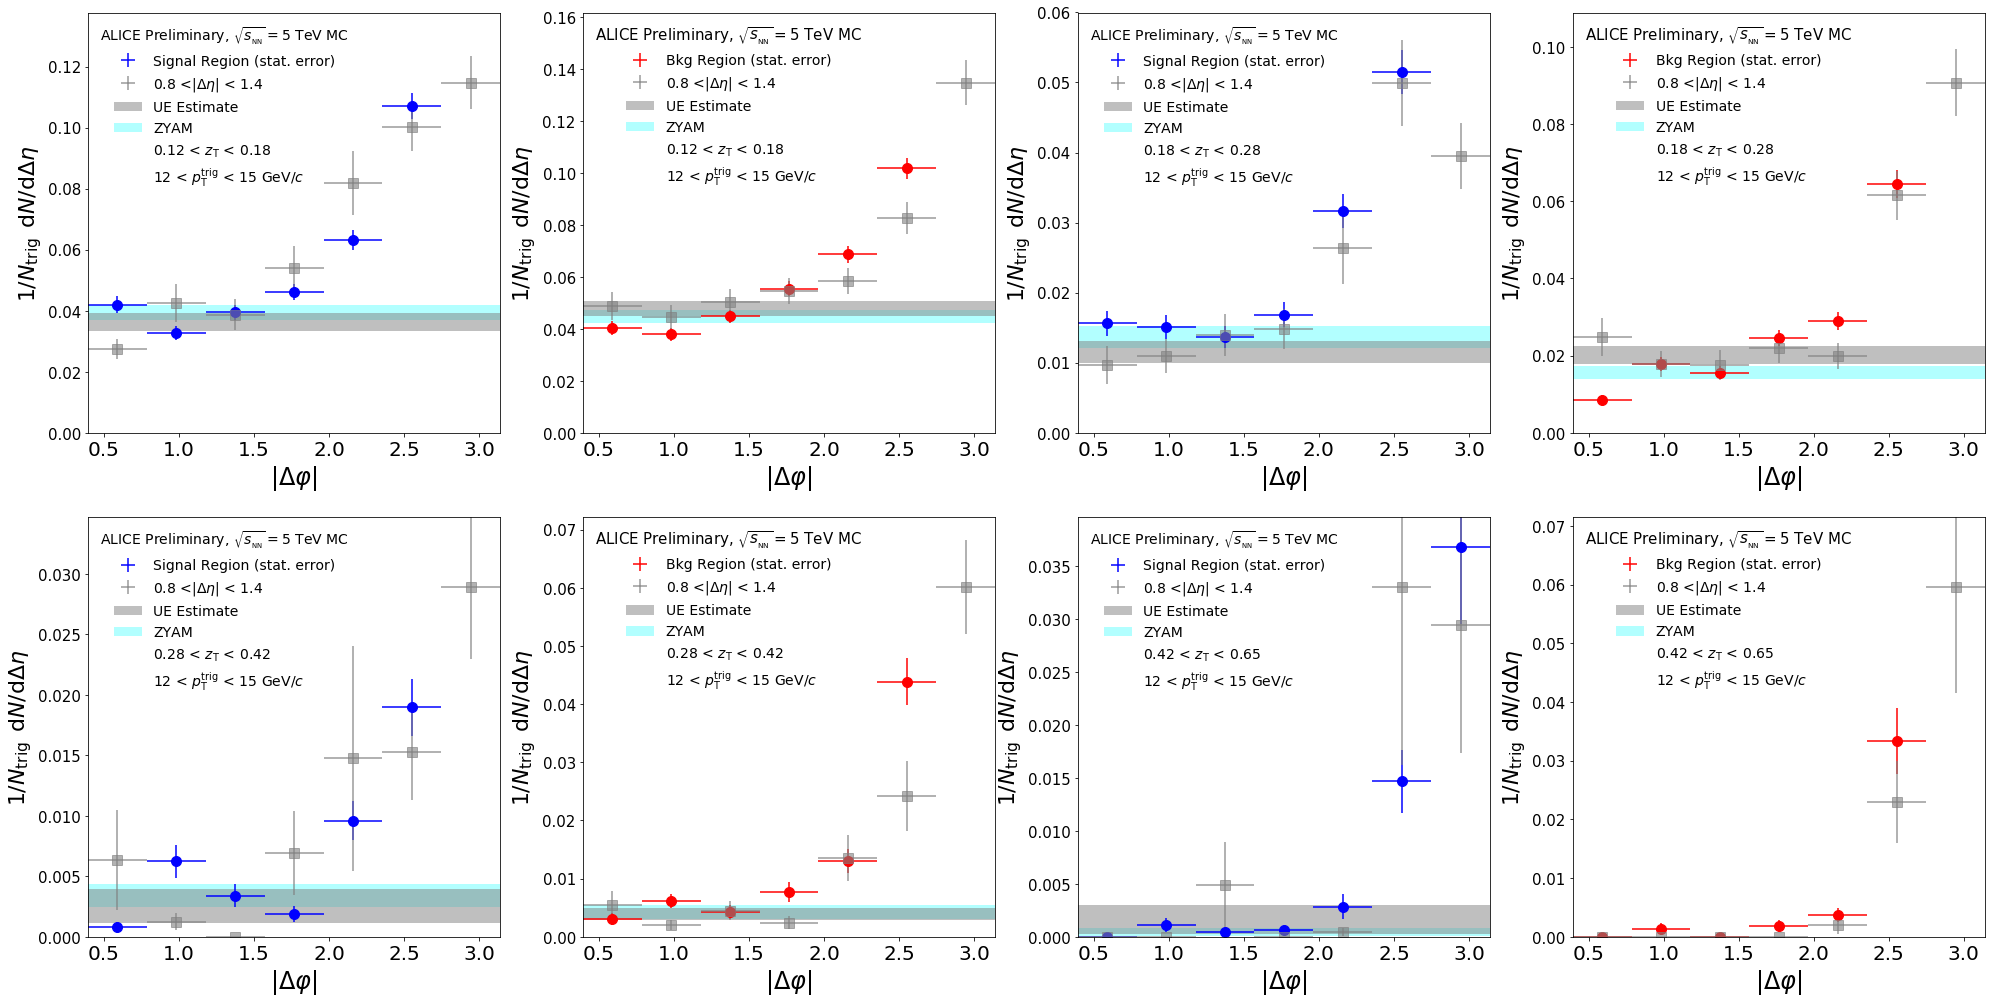

In [12]:
for sys,ifile in zip(Systems,Files):
    print(" $z_T$ interval   & LE Signal Region & LE Background Region & ZYAM Signal Region & ZYAM Background Region")
    fig = plt.figure(figsize=(34,17))
    for ipt in range (3):
        if (ipt > 0): continue
        ipt = ipt+2
        for izt in range (zT_offset,NzT+zT_offset):
            
            ztb = izt-zT_offset
            
            Sig_LE_Phi_Array, Sig_LE_Error_Array = GetLEProj(ifile, ipt, izt, True,False)
            Bkg_LE_Phi_Array, Bkg_LE_Error_Array = GetLEProj(ifile, ipt, izt, False,False)

            S_LE, S_LE_Error = GetLE_Val(Sig_LE_Phi_Array, Sig_LE_Error_Array)
            Bkg_LE, Bkg_LE_Error = GetLE_Val(Bkg_LE_Phi_Array, Bkg_LE_Error_Array)


            Sig_Phi_Array, Sig_Phi_Error_Array = GetPhiProj(ifile,sys,ipt,izt,True)
            Bkg_Phi_Array, Bkg_Phi_Error_Array = GetPhiProj(ifile,sys,ipt,izt,False)


            Sig_Z_Value,Sig_Z_Error = ZYAM_Line(Sig_Phi_Array, Sig_Phi_Error_Array)
            Bkg_Z_Value,Bkg_Z_Error = ZYAM_Line(Bkg_Phi_Array, Bkg_Phi_Error_Array)

            print("%1.2f - %1.2f & %1.3f $\pm$ %1.3f & %1.3f $\pm$ %1.3f & %1.3f $\pm$ %1.3f & %1.3f $\pm$ %1.4f \\\\"
                  %(zTbins[izt],zTbins[izt+1],S_LE,S_LE_Error,Bkg_LE,Bkg_LE_Error,Sig_Z_Value,Sig_Z_Error,Bkg_Z_Value,Bkg_Z_Error))

                                            
                                        #--------------plot--------------------#
           
            if (NzT ==4):
                ax = fig.add_subplot(2,4,(2*ztb+1))
            elif (NzT ==6):
                ax = fig.add_subplot(3,4,(2*ztb+1))
                
            fsize = 20

            #sig
            ax.plot(delta_phi_centers,Sig_Phi_Array,'bo',ms=10)
            s_plot = ax.errorbar(delta_phi_centers,Sig_Phi_Array,xerr=phi_width,yerr=Sig_Phi_Error_Array,fmt=None,ecolor='b',label='Signal Region (stat. error)')

            ax.plot(delta_phi_centers,Sig_LE_Phi_Array,'s',color="Grey",alpha=0.6,ms=10)
            s_le_plot = ax.errorbar(delta_phi_centers,Sig_LE_Phi_Array,xerr=phi_width,yerr=Sig_LE_Error_Array,fmt=None,ecolor='Grey',alpha=0.8,label="0.8 <|$\Delta\eta$| < 1.4")

            plt.xlabel(r'|$\Delta \varphi$|',fontsize=fsize+4)
            plt.xticks(fontsize=(fsize))
            plt.xlim((0.39269908169872414,3.14159))
            plt.ylabel(r'$1/N_{\mathrm{trig}} \: \: \mathrm{d}N/\mathrm{d}\Delta\eta$',fontsize=fsize+2)
            plt.ylim((0,1.2*max(Sig_LE_Phi_Array)))
            empt, = ax.plot([], [], ' ')
            empt2, = ax.plot([],[],' ')
            plt.yticks(fontsize=fsize-5)

            fill_x = [0,3.14159]
            s_z_line = ax.fill_between(fill_x, Sig_Z_Value-Sig_Z_Error,Sig_Z_Value+Sig_Z_Error,interpolate=False,edgecolor='cyan',linewidth=0.0, alpha=0.3,facecolor='cyan')
            s_le_line = ax.fill_between(fill_x, S_LE-S_LE_Error,S_LE+S_LE_Error,interpolate=False,edgecolor='grey',linewidth=0.0, alpha=0.5,facecolor='grey')

            leg = ax.legend([s_plot,s_le_plot,s_le_line,s_z_line,empt,empt2],['Signal Region (stat. error)','0.8 <|$\Delta\eta$| < 1.4','UE Estimate',
                'ZYAM',r'%1.2f < $z_\mathrm{T}$ < %1.2f'%(zTbins[izt],zTbins[izt+1]),r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1])],
                loc='best',title = "Alice Preliminary %s 5 TeV",fontsize=14,frameon=False,numpoints=1)
            if (sys == 'pp'):
                leg.set_title("ALICE Preliminary, $\sqrt{s}=$5 TeV %s"%(sys))
            else:
                leg.set_title("ALICE Preliminary, $\sqrt{s_{\mathrm{_{NN}}}}=$5 TeV %s"%(sys))                
            plt.setp(leg.get_title(),fontsize=14)


            #bkg
            if (NzT ==4):
                ax = fig.add_subplot(2,4,(2*ztb+2))
            elif (NzT ==6):
                ax = fig.add_subplot(3,4,(2*ztb+2))
                
            #ax = fig.add_subplot(1,2,1)
            plt.xlabel(r'|$\Delta \varphi$|',fontsize=fsize+4)
            plt.xticks(fontsize=(fsize))
            plt.xlim((0.39269908169872414,3.14159))
            plt.ylabel(r'$1/N_{\mathrm{trig}} \: \: \mathrm{d}N/\mathrm{d}\Delta\eta$',fontsize=fsize+2)
            plt.ylim((0,1.2*max(Bkg_LE_Phi_Array)))
            plt.yticks(fontsize=fsize-5)

            fill_x = [0,3.14149]
            b_z_line = plt.fill_between(fill_x, Bkg_Z_Value-Bkg_Z_Error,Bkg_Z_Value+Bkg_Z_Error,interpolate=False,edgecolor='cyan',linewidth=0.0, alpha=0.3,facecolor='cyan')
            b_le_line = plt.fill_between(fill_x, Bkg_LE-Bkg_LE_Error,Bkg_LE+Bkg_LE_Error,interpolate=False,edgecolor='grey',linewidth=0.0, alpha=0.5,facecolor='grey')

            ax.plot(delta_phi_centers,Bkg_Phi_Array,'ro',ms=10)
            b_plot = ax.errorbar(delta_phi_centers,Bkg_Phi_Array,xerr=phi_width,yerr=Bkg_Phi_Error_Array,fmt=None,ecolor='r')

            plt.plot(delta_phi_centers,Bkg_LE_Phi_Array,'s',color="Grey",alpha=0.6,ms=10)

            b_le_plot =plt.errorbar(delta_phi_centers,Bkg_LE_Phi_Array,xerr=phi_width,yerr=Bkg_LE_Error_Array,fmt=None,ecolor='Grey',alpha=0.8)
            leg = ax.legend([b_plot,b_le_plot,b_le_line,b_z_line,empt,empt2],['Bkg Region (stat. error)','0.8 <|$\Delta\eta$| < 1.4','UE Estimate',
                'ZYAM',r'%1.2f < $z_\mathrm{T}$ < %1.2f'%(zTbins[izt],zTbins[izt+1]),r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1])],
                loc='best',fontsize=14,frameon=False,numpoints=1)
            if (sys == 'pp'):
                leg.set_title("ALICE Preliminary, $\sqrt{s}=$5 TeV %s"%(sys))
            else:
                leg.set_title("ALICE Preliminary, $\sqrt{s_{\mathrm{_{NN}}}}=$5 TeV %s"%(sys))
            plt.setp(leg.get_title(),fontsize=15)
            fig.savefig('pics/%s_Gamma_hadron_UE_zT_%i.pdf'%(sys,izt), bbox_inches='tight')        
    print("")
    #return


Made the decision to not declare global np.arrays containing the plot data until after UE subtraction. This way there are only two sets of arrays for each system, background and signal regions with their errors (no LE or ZYAM data structures).

# Subtract UE and Start Using Global Arrays

In [13]:
 #Number of zT bins, subject to change

#Global Arrays
pp_CSR = np.zeros((NzT,len(delta_phi_centers)))
pp_CSR_Errors = np.zeros((NzT,len(delta_phi_centers)))
pp_CBR = np.zeros((NzT,len(delta_phi_centers)))
pp_CBR_Errors = np.zeros((NzT,len(delta_phi_centers)))

pPb_CSR = np.zeros((NzT,len(delta_phi_centers)))
pPb_CSR_Errors = np.zeros((NzT,len(delta_phi_centers)))
pPb_CBR = np.zeros((NzT,len(delta_phi_centers)))
pPb_CBR_Errors = np.zeros((NzT,len(delta_phi_centers)))

MC_CSR = np.zeros((NzT,len(delta_phi_centers)))
MC_CSR_Errors = np.zeros((NzT,len(delta_phi_centers)))
MC_CBR = np.zeros((NzT,len(delta_phi_centers)))
MC_CBR_Errors = np.zeros((NzT,len(delta_phi_centers)))

pp_LE_Error = np.zeros(NzT)
pPb_LE_Error = np.zeros(NzT)

MC_LE_Error = np.zeros(NzT)

for sys,ifile in zip(Systems,Files):
    if (sys == "p-Pb"):
        SYS = "pPb" #can't have -
    else:
        SYS=sys
        
    for ipt in range (3):
        if (ipt > 0): continue
        ipt = ipt+2
        for izt in range (zT_offset,NzT+zT_offset):
            ztb = izt-zT_offset
            Sig_LE_Phi_Array, Sig_LE_Error_Array = GetLEProj(ifile, ipt, izt, True,True) # Using AVERAGE LE
            Bkg_LE_Phi_Array, Bkg_LE_Error_Array = GetLEProj(ifile, ipt, izt, False,True) # Using AVERAGE LE

            S_LE, S_LE_Error = GetLE_Val(Sig_LE_Phi_Array, Sig_LE_Error_Array)
            Bkg_LE, Bkg_LE_Error = GetLE_Val(Bkg_LE_Phi_Array, Bkg_LE_Error_Array)


            Sig_Phi_Array, Sig_Phi_Error_Array = GetPhiProj(ifile,sys,ipt,izt,True)
            Bkg_Phi_Array, Bkg_Phi_Error_Array = GetPhiProj(ifile,sys,ipt,izt,False)

            Sig_Phi_Array -= S_LE
            Bkg_Phi_Array -= Bkg_LE
            vars()["%s_CSR"%(SYS)][ztb] = Sig_Phi_Array
            vars()["%s_CSR_Errors"%(SYS)][ztb] = Sig_Phi_Error_Array
            
            vars()["%s_CBR"%(SYS)][ztb] = Bkg_Phi_Array
            vars()["%s_CBR_Errors"%(SYS)][ztb] = Bkg_Phi_Error_Array
            
            vars()["%s_LE_Error"%(SYS)][ztb] = S_LE_Error

# Plot UE Sub. with Uncertainties

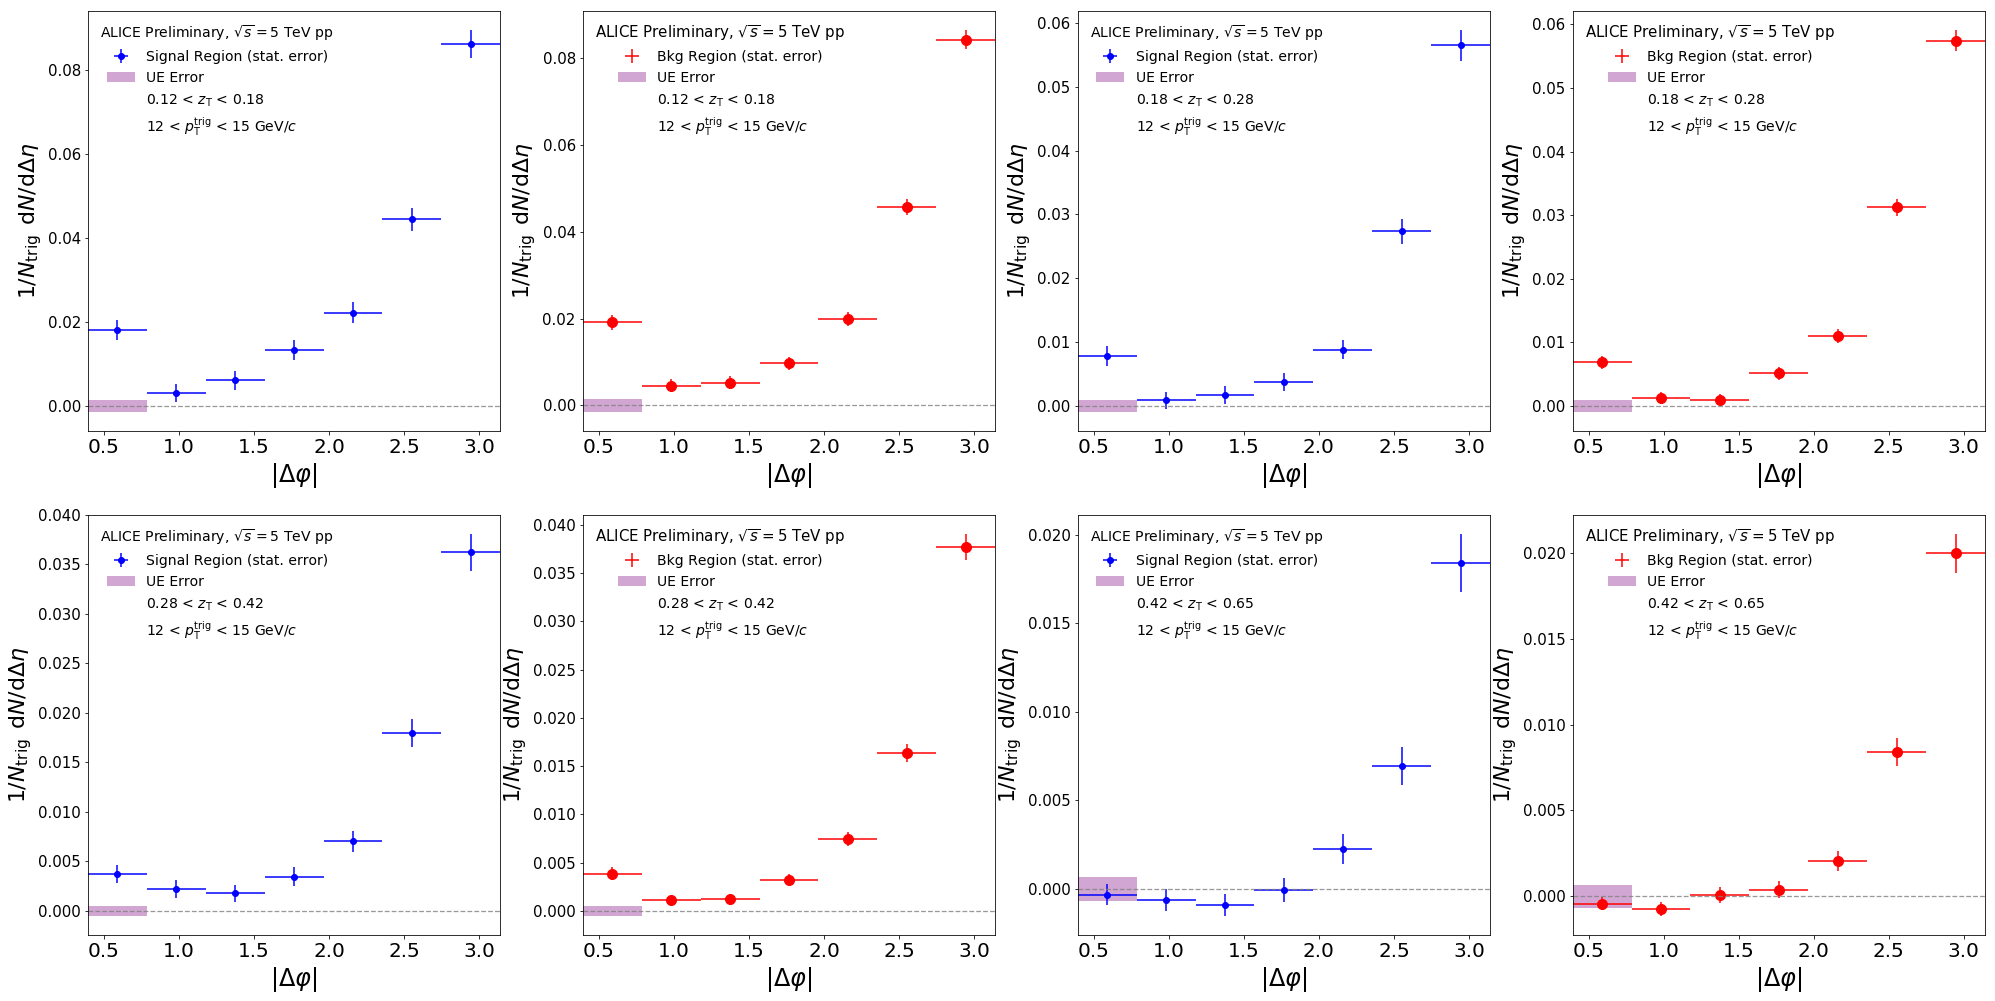

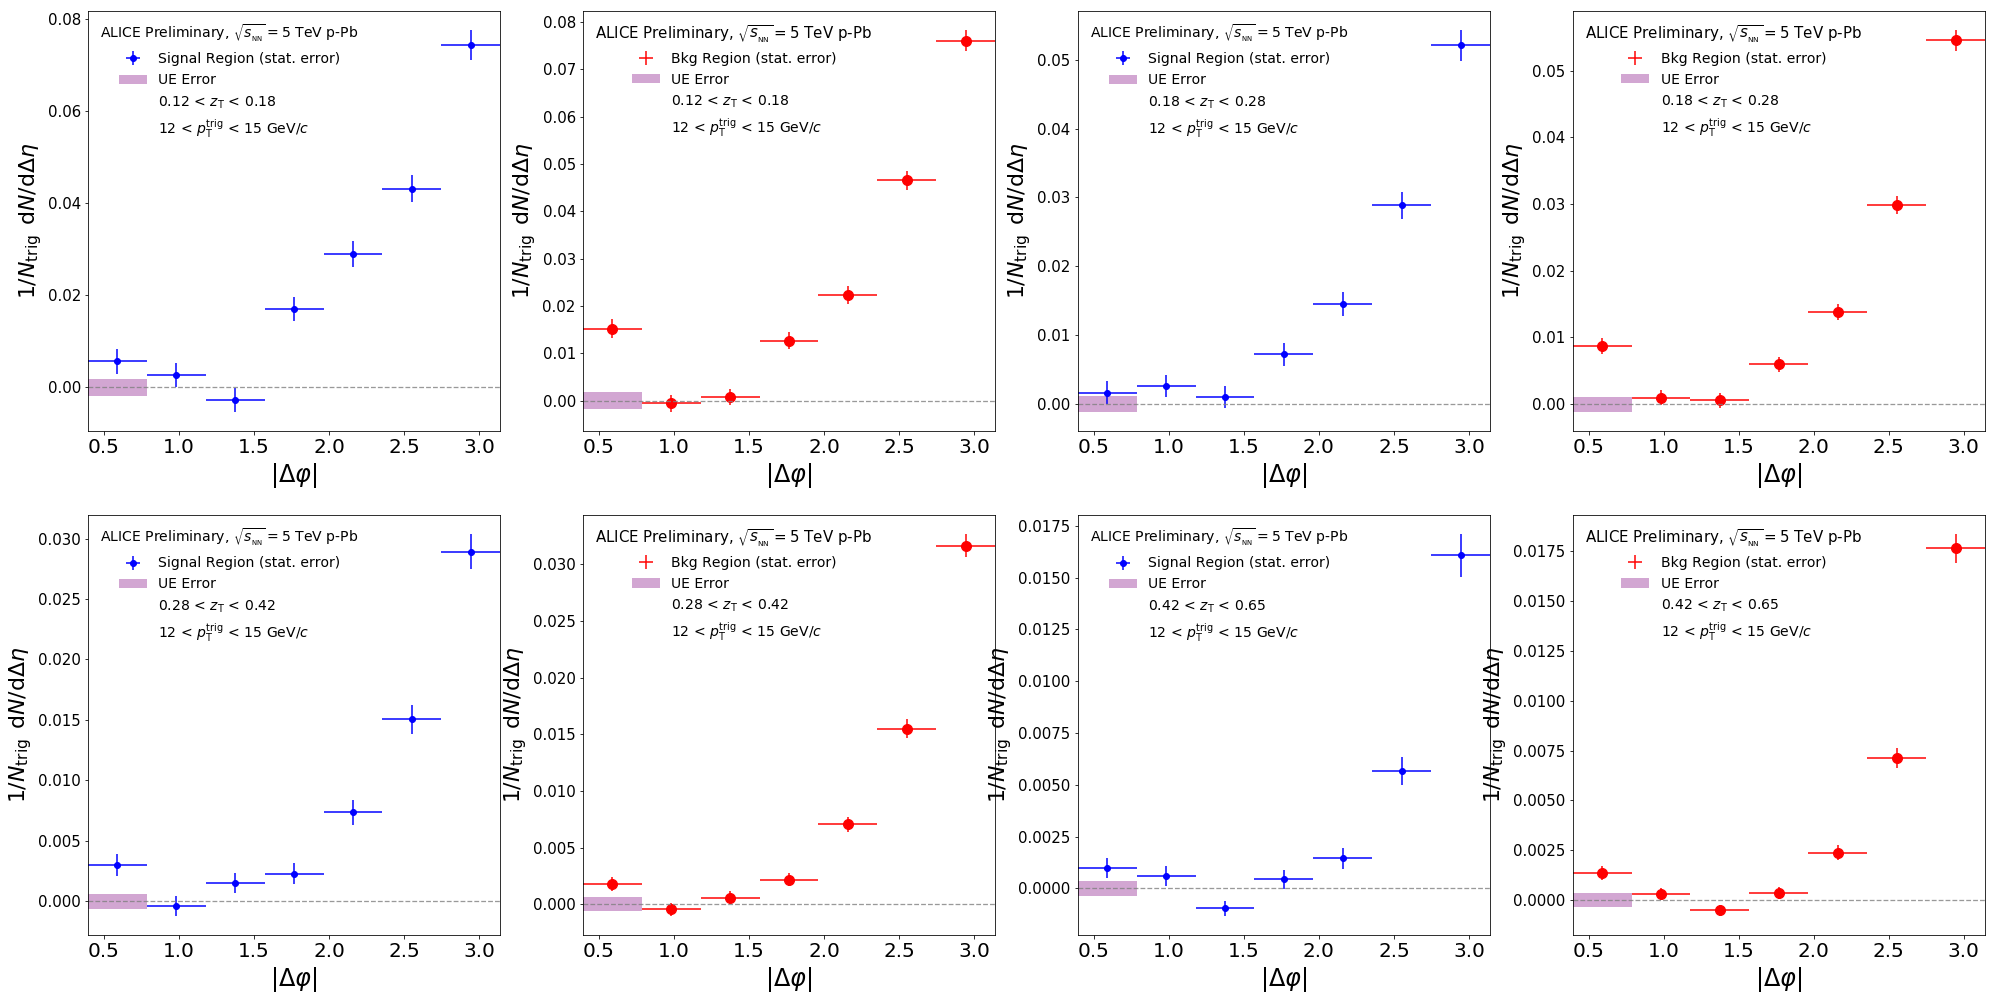

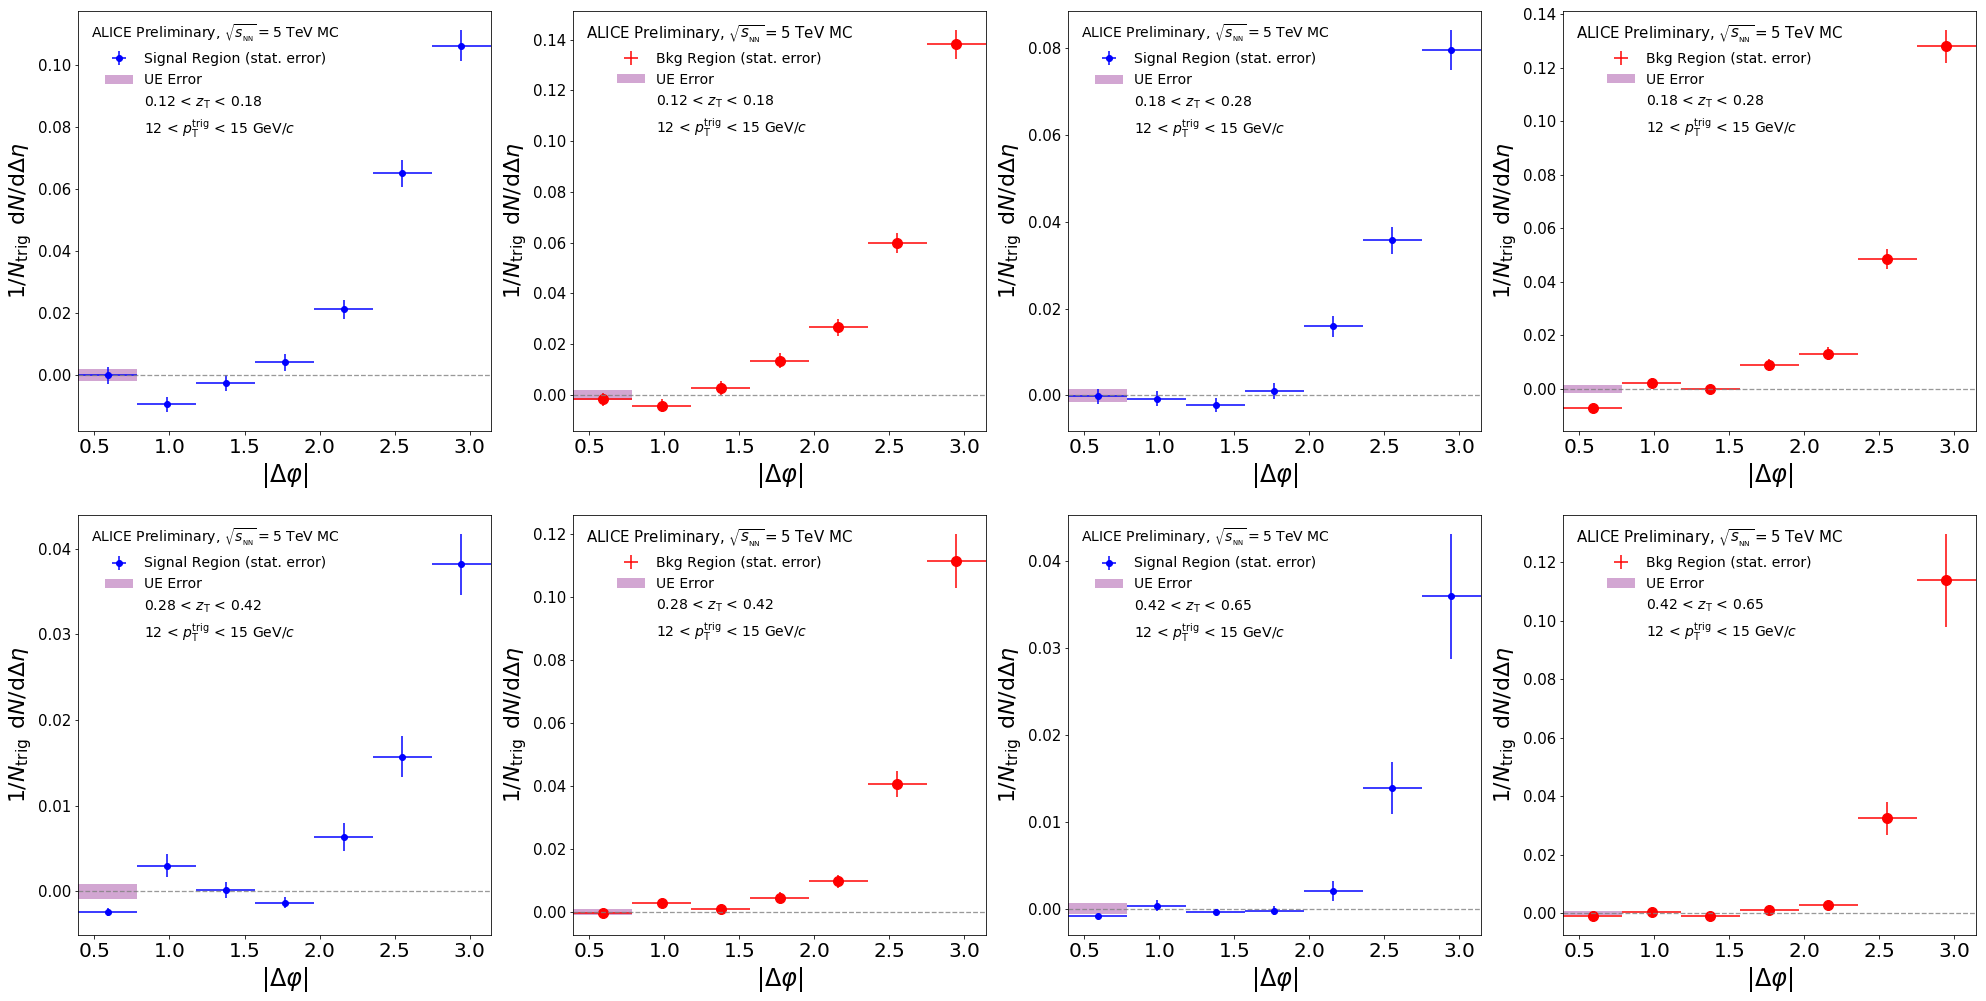

In [14]:
fsize = 20
for sys,ifile in zip(Systems,Files):
    
    if (sys == "p-Pb"):
        SYS = "pPb" #can't have -
    else:
        SYS=sys
        
    fig = plt.figure(figsize=(34,17))
    for ipt in range (3):
        if (ipt > 0): continue
        ipt = ipt+2
        for izt in range (zT_offset,NzT+zT_offset):
            ztb = izt-zT_offset
            
            #sig
            if (NzT ==4):
                ax = fig.add_subplot(2,4,(2*ztb+1))
            elif (NzT ==6):
                ax = fig.add_subplot(3,4,(2*ztb+1))
            #ax.plot(delta_phi_centers,vars()["%s_CSR"%(SYS)][ztb],'bo',ms=10)
            s_plot = ax.errorbar(delta_phi_centers,vars()["%s_CSR"%(SYS)][ztb],xerr=phi_width,
                yerr=vars()["%s_CSR_Errors"%(SYS)][ztb],fmt='bo',ecolor='b',label='Signal Region (stat. error)')
            
            UE_Band = ax.fill_between(ue_error_bar,-vars()["%s_LE_Error"%(SYS)][ztb],
                vars()["%s_LE_Error"%(SYS)][ztb],facecolor='purple',alpha=0.35) 
            
            plt.axhline(y=0,color='gray',linestyle='--',linewidth=1.3,alpha=0.8)

            
            plt.xlabel(r'|$\Delta \varphi$|',fontsize=fsize+4)
            plt.xticks(fontsize=(fsize))
            plt.xlim((0.39269908169872414,3.14159))
            plt.ylabel(r'$1/N_{\mathrm{trig}} \: \: \mathrm{d}N/\mathrm{d}\Delta\eta$',fontsize=fsize+2)
            empt, = ax.plot([], [], ' ')
            empt2, = ax.plot([],[],' ')
            plt.yticks(fontsize=fsize-5)

            leg = ax.legend([s_plot,UE_Band,empt,empt2],['Signal Region (stat. error)',"UE Error",r'%1.2f < $z_\mathrm{T}$ < %1.2f'
                %(zTbins[izt],zTbins[izt+1]),r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1])],
                loc='best',title = "Alice Preliminary %s 5 TeV",fontsize=14,frameon=False,numpoints=1)
            
            if (sys == 'pp'):
                leg.set_title("ALICE Preliminary, $\sqrt{s}=$5 TeV %s"%(sys))
            else:
                leg.set_title("ALICE Preliminary, $\sqrt{s_{\mathrm{_{NN}}}}=$5 TeV %s"%(sys))                
            plt.setp(leg.get_title(),fontsize=14)


            #bkg
            if (NzT ==4):
                ax = fig.add_subplot(2,4,(2*ztb+2))
            elif (NzT ==6):
                ax = fig.add_subplot(3,4,(2*ztb+2))
                
            plt.xlabel(r'|$\Delta \varphi$|',fontsize=fsize+4)
            plt.xticks(fontsize=(fsize))
            plt.xlim((0.39269908169872414,3.14159))
            plt.ylabel(r'$1/N_{\mathrm{trig}} \: \: \mathrm{d}N/\mathrm{d}\Delta\eta$',fontsize=fsize+2)
            plt.yticks(fontsize=fsize-5)

            ax.plot(delta_phi_centers,vars()["%s_CBR"%(SYS)][ztb],'ro',ms=10)
            b_plot = ax.errorbar(delta_phi_centers,vars()["%s_CBR"%(SYS)][ztb],xerr=phi_width,yerr=vars()["%s_CBR_Errors"%(SYS)][ztb],fmt=None,ecolor='r')
            UE_Band = ax.fill_between(ue_error_bar,-vars()["%s_LE_Error"%(SYS)][ztb],vars()["%s_LE_Error"%(SYS)][ztb],facecolor='purple',alpha=0.35) 
            plt.axhline(y=0,color='gray',linestyle='--',linewidth=1.3,alpha=0.8)
            
            
            leg = ax.legend([b_plot,UE_Band,empt,empt2],['Bkg Region (stat. error)',"UE Error",r'%1.2f < $z_\mathrm{T}$ < %1.2f'
                %(zTbins[izt],zTbins[izt+1]),r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1])],
                loc='best',fontsize=14,frameon=False,numpoints=1)
            if (sys == 'pp'):
                leg.set_title("ALICE Preliminary, $\sqrt{s}=$5 TeV %s"%(sys))
            else:
                leg.set_title("ALICE Preliminary, $\sqrt{s_{\mathrm{_{NN}}}}=$5 TeV %s"%(sys))
            plt.setp(leg.get_title(),fontsize=15)
            fig.savefig('pics/%s_Gamma_hadron_UE_zT_%i.pdf'%(sys,izt), bbox_inches='tight')

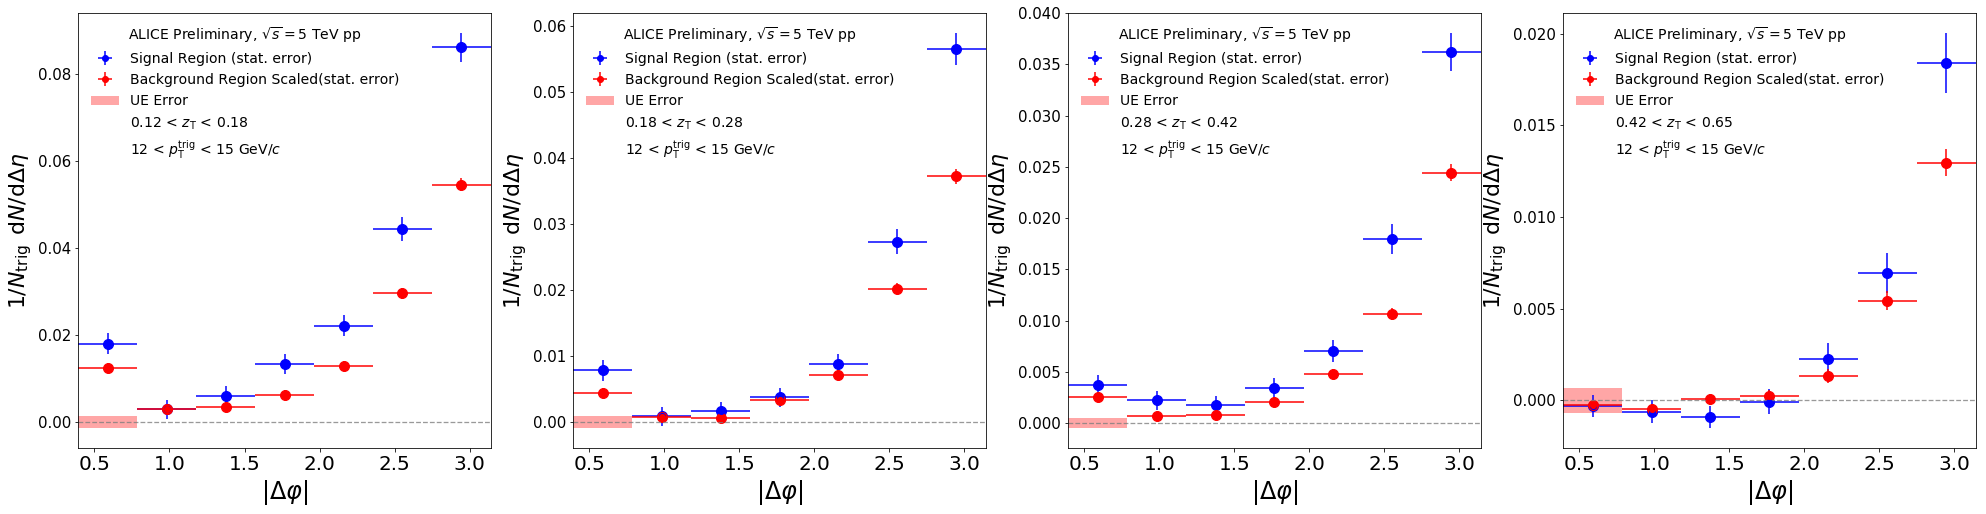

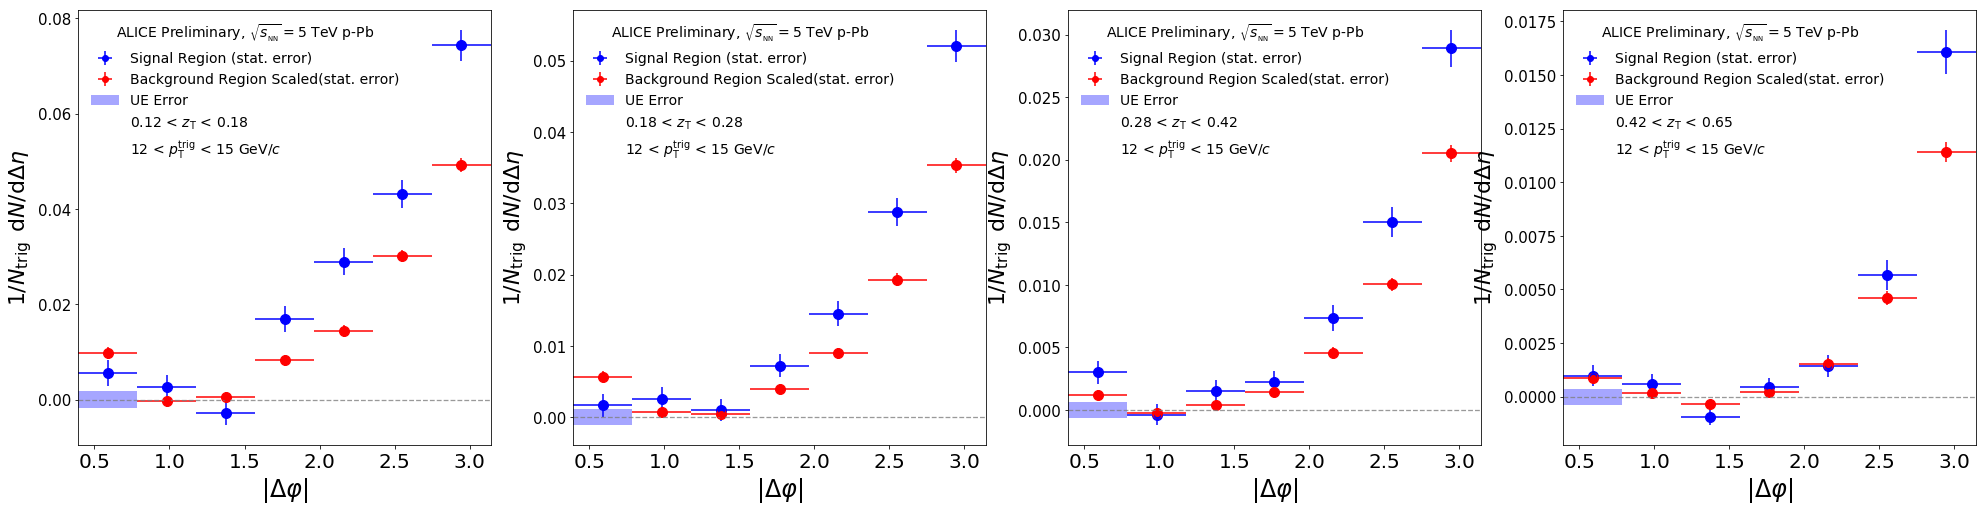

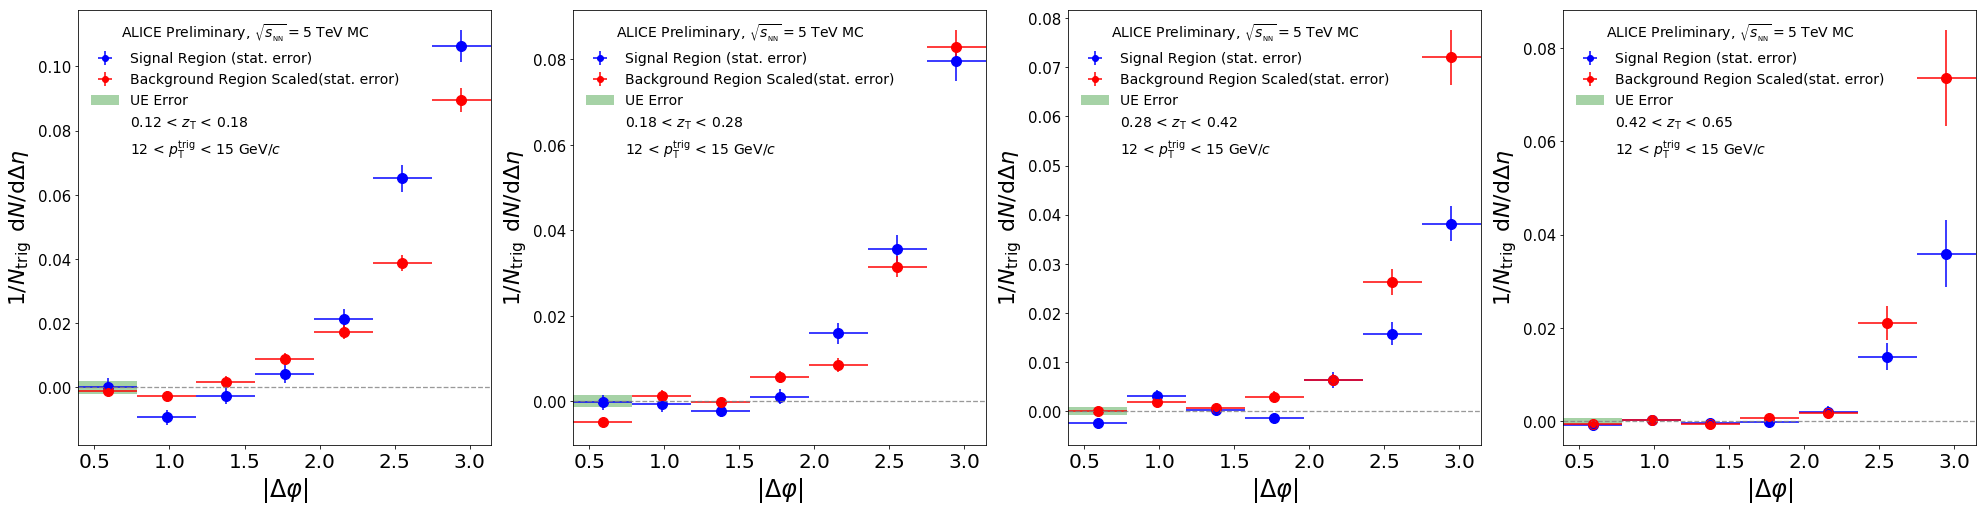

In [15]:
for sys,ifile in zip(Systems,Files):
    
    SYS=sys
    
    if (sys == "p-Pb"):
        SYS = "pPb" #can't have -
        sys_color = 'blue'
    elif(sys == "pp"):
        sys_color = 'red'
    elif(sys == "MC"):
         sys_color = 'green'
        
    fig = plt.figure(figsize=(34,8))
    for ipt in range (3):
        if (ipt > 0): continue
        ipt = ipt+2
        for izt in range (zT_offset,NzT+zT_offset):
            ztb = izt-zT_offset
            
            if (NzT == 4):
                ax = fig.add_subplot(1,4,(ztb+1))
            elif (NzT == 6):
                ax = fig.add_subplot(1,6,(ztb+1))
            
            ax.plot(delta_phi_centers,vars()["%s_CSR"%(SYS)][ztb],'bo',color="blue",ms=10)
            s_plot = ax.errorbar(delta_phi_centers,vars()["%s_CSR"%(SYS)][ztb],xerr=phi_width,
                yerr=vars()["%s_CSR_Errors"%(SYS)][ztb],fmt='bo',ecolor="blue",label='Signal Region (stat. error)')
            
            ax.plot(delta_phi_centers,vars()["%s_CBR"%(SYS)][ztb]*(1-purity),'ro',color="red",ms=10)
            b_plot = ax.errorbar(delta_phi_centers,vars()["%s_CBR"%(SYS)][ztb]*(1-purity),xerr=phi_width,
                yerr=vars()["%s_CBR_Errors"%(SYS)][ztb]*(1-purity),fmt='ro',ecolor="red",label='Background Region (stat. error)')
            
            UE_Band = ax.fill_between(ue_error_bar,-vars()["%s_LE_Error"%(SYS)][ztb],vars()["%s_LE_Error"%(SYS)][ztb],facecolor=sys_color,alpha=0.35) 
            plt.axhline(y=0,color='gray',linestyle='--',linewidth=1.3,alpha=0.8)


            plt.xlabel(r'|$\Delta \varphi$|',fontsize=fsize+4)
            plt.xticks(fontsize=(fsize))
            plt.xlim((0.39269908169872414,3.14159))
            plt.ylabel(r'$1/N_{\mathrm{trig}} \: \: \mathrm{d}N/\mathrm{d}\Delta\eta$',fontsize=fsize+2)
            #plt.ylim((0,1.2*max(Sig_LE_Phi_Array)))
            empt, = ax.plot([], [], ' ')
            empt2, = ax.plot([],[],' ')
            plt.yticks(fontsize=fsize-5)

            leg = ax.legend([s_plot,b_plot,UE_Band,empt,empt2],['Signal Region (stat. error)','Background Region Scaled(stat. error)',
                "UE Error",r'%1.2f < $z_\mathrm{T}$ < %1.2f'%(zTbins[izt],zTbins[izt+1]),r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1])],
                loc='best',title = "Alice Preliminary %s 5 TeV",fontsize=14,frameon=False,numpoints=1)
            if (sys == 'pp'):
                leg.set_title("ALICE Preliminary, $\sqrt{s}=$5 TeV %s"%(sys))
            else:
                leg.set_title("ALICE Preliminary, $\sqrt{s_{\mathrm{_{NN}}}}=$5 TeV %s"%(sys))                
            plt.setp(leg.get_title(),fontsize=14)

# Purity Scaling + Correlated Subtraction

## Subtraction: $C_{S} = \frac{C_{SR} - (1-p) C_{BR}}{p}$

In [16]:
pp_CSR = (pp_CSR - (1-purity)*pp_CBR)/purity
pPb_CSR = (pPb_CSR - (1-purity)*pPb_CBR)/purity

pp_CSR_Errors = pp_CSR_Errors/purity
pPb_CSR_Errors = pPb_CSR_Errors/purity

pp_LE_Error = pp_LE_Error/purity
pPb_LE_Error = pPb_LE_Error/purity

## Apply Corrections

In [17]:
def Apply_Corrections(Phi_Array):
   
    Efficiency = 0.85
    Correction_reduced = Corrections[zT_offset:NzT+zT_offset]
    oneminFake_reduced = oneminFake[zT_offset:NzT+zT_offset]
    
    #####  Single Track Efficiency  #####
    Phi_Array = Phi_Array/Efficiency
 
    for izt in range(4):
        
        #####  Track pT Binning Correction  #####
        temp_corr = Correction_reduced[izt]
        Phi_Array = Phi_Array*temp_corr

        ##### 1 - Fake Rate Correction. #####
        temp_fake = oneminFake_reduced[izt]
        Phi_Array = Phi_Array*temp_fake

In [18]:
for ztb in range (NzT):
    Apply_Corrections(pp_CSR[ztb])
    Apply_Corrections(pp_CSR_Errors[ztb])

    Apply_Corrections(pPb_CSR[ztb])
    Apply_Corrections(pPb_CSR_Errors[ztb])
    
    Apply_Corrections(pp_LE_Error[ztb])
    Apply_Corrections(pPb_LE_Error[ztb])

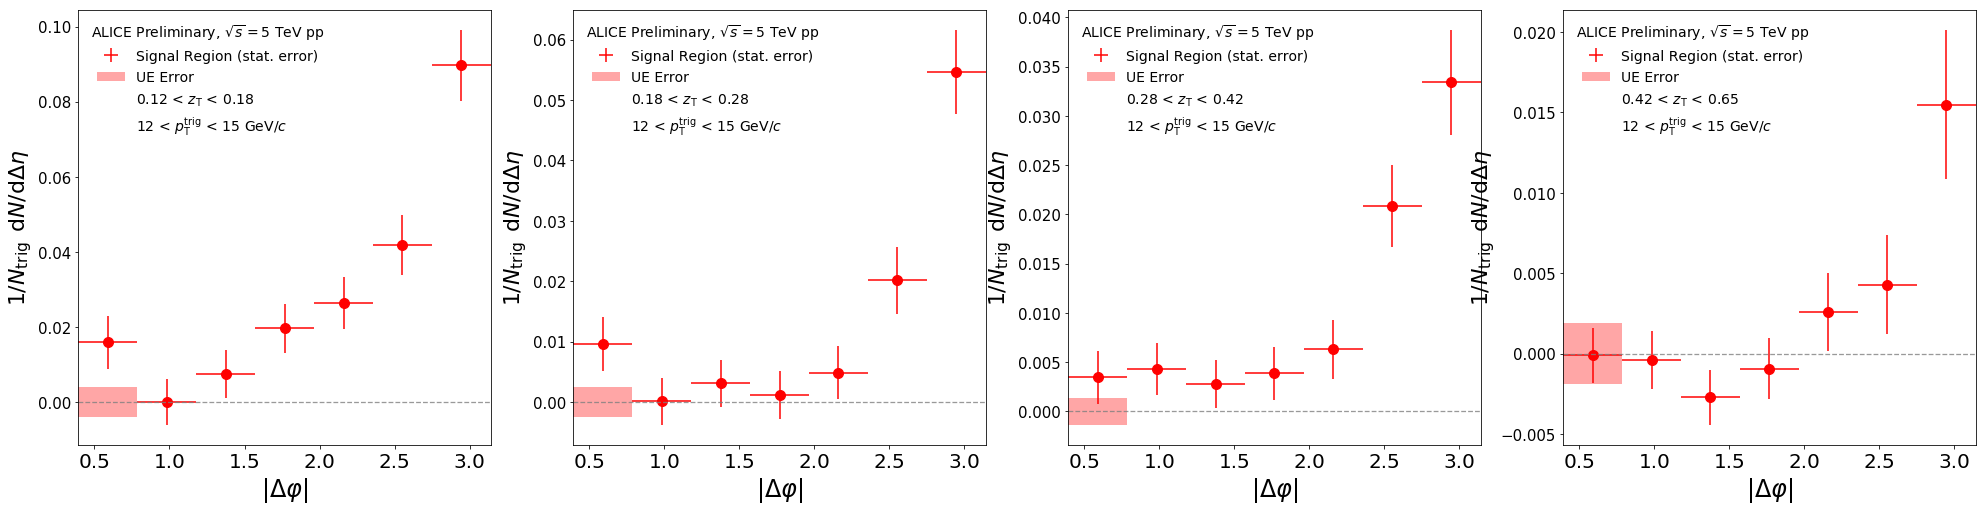

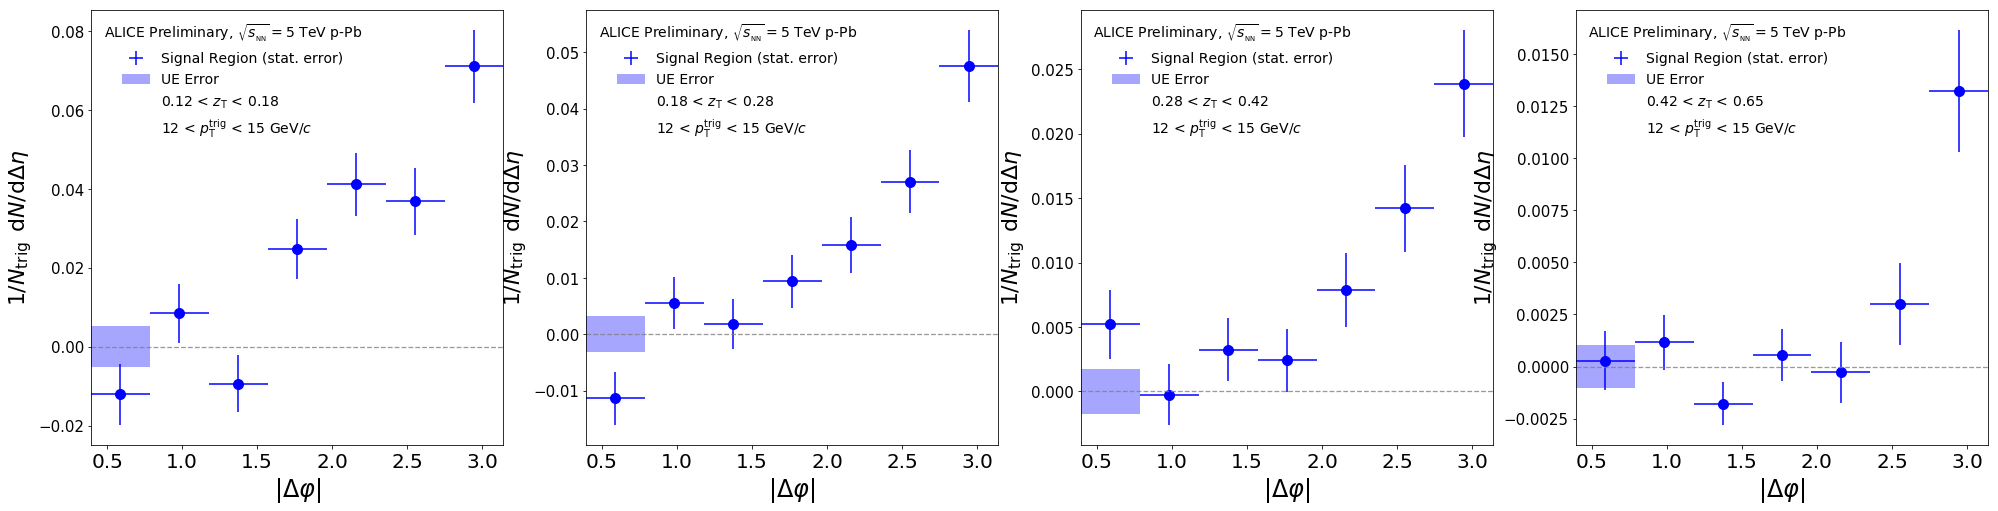

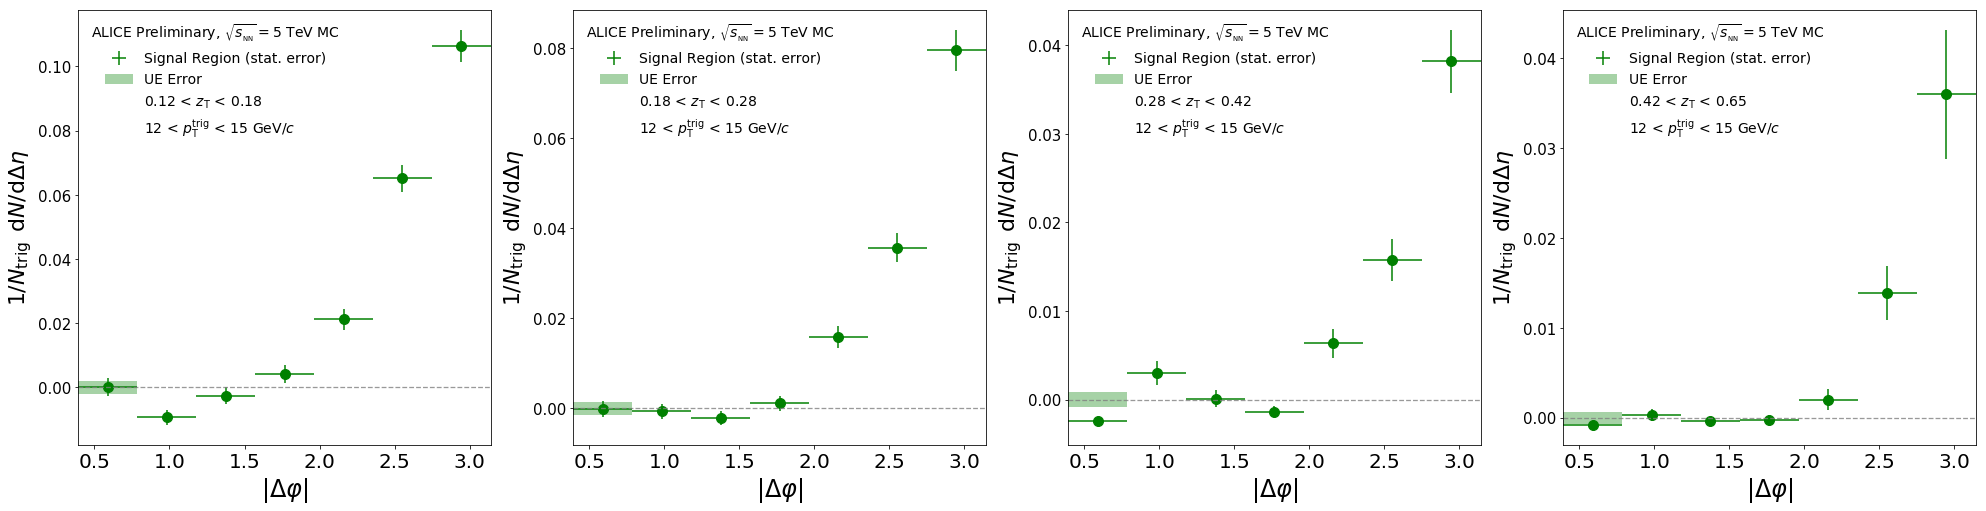

In [19]:
for sys,ifile in zip(Systems,Files):
    
    SYS=sys
    
    if (sys == "p-Pb"):
        SYS = "pPb" #can't have -
        sys_color = 'blue'
    elif(sys == "pp"):
        sys_color = 'red'
    elif(sys == "MC"):
         sys_color = 'green'
         
         
    fig = plt.figure(figsize=(34,8))
    for ipt in range (3):
        if (ipt > 0): continue
        ipt = ipt+2
        for izt in range (zT_offset,NzT+zT_offset):
            ztb = izt-zT_offset
            
            if (NzT == 4):
                ax = fig.add_subplot(1,4,(ztb+1))
            elif (NzT == 6):
                ax = fig.add_subplot(1,6,(ztb+1))
            
            ax.plot(delta_phi_centers,vars()["%s_CSR"%(SYS)][ztb],'bo',color=sys_color,ms=10)
            s_plot = ax.errorbar(delta_phi_centers,vars()["%s_CSR"%(SYS)][ztb],xerr=phi_width,
                yerr=vars()["%s_CSR_Errors"%(SYS)][ztb],fmt=None,ecolor=sys_color,label='Signal Region (stat. error)')
            UE_Band = ax.fill_between(ue_error_bar,-vars()["%s_LE_Error"%(SYS)][ztb],vars()["%s_LE_Error"%(SYS)][ztb],facecolor=sys_color,alpha=0.35) 
            plt.axhline(y=0,color='gray',linestyle='--',linewidth=1.3,alpha=0.8)


            plt.xlabel(r'|$\Delta \varphi$|',fontsize=fsize+4)
            plt.xticks(fontsize=(fsize))
            plt.xlim((0.39269908169872414,3.14159))
            plt.ylabel(r'$1/N_{\mathrm{trig}} \: \: \mathrm{d}N/\mathrm{d}\Delta\eta$',fontsize=fsize+2)
            #plt.ylim((0,1.2*max(Sig_LE_Phi_Array)))
            empt, = ax.plot([], [], ' ')
            empt2, = ax.plot([],[],' ')
            plt.yticks(fontsize=fsize-5)

            leg = ax.legend([s_plot,UE_Band,empt,empt2],['Signal Region (stat. error)',"UE Error",r'%1.2f < $z_\mathrm{T}$ < %1.2f'
                %(zTbins[izt],zTbins[izt+1]),r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1])],
                loc='best',title = "Alice Preliminary %s 5 TeV",fontsize=14,frameon=False,numpoints=1)
            if (sys == 'pp'):
                leg.set_title("ALICE Preliminary, $\sqrt{s}=$5 TeV %s"%(sys))
            else:
                leg.set_title("ALICE Preliminary, $\sqrt{s_{\mathrm{_{NN}}}}=$5 TeV %s"%(sys))                
            plt.setp(leg.get_title(),fontsize=14)

# Overlay pp and p-Pb

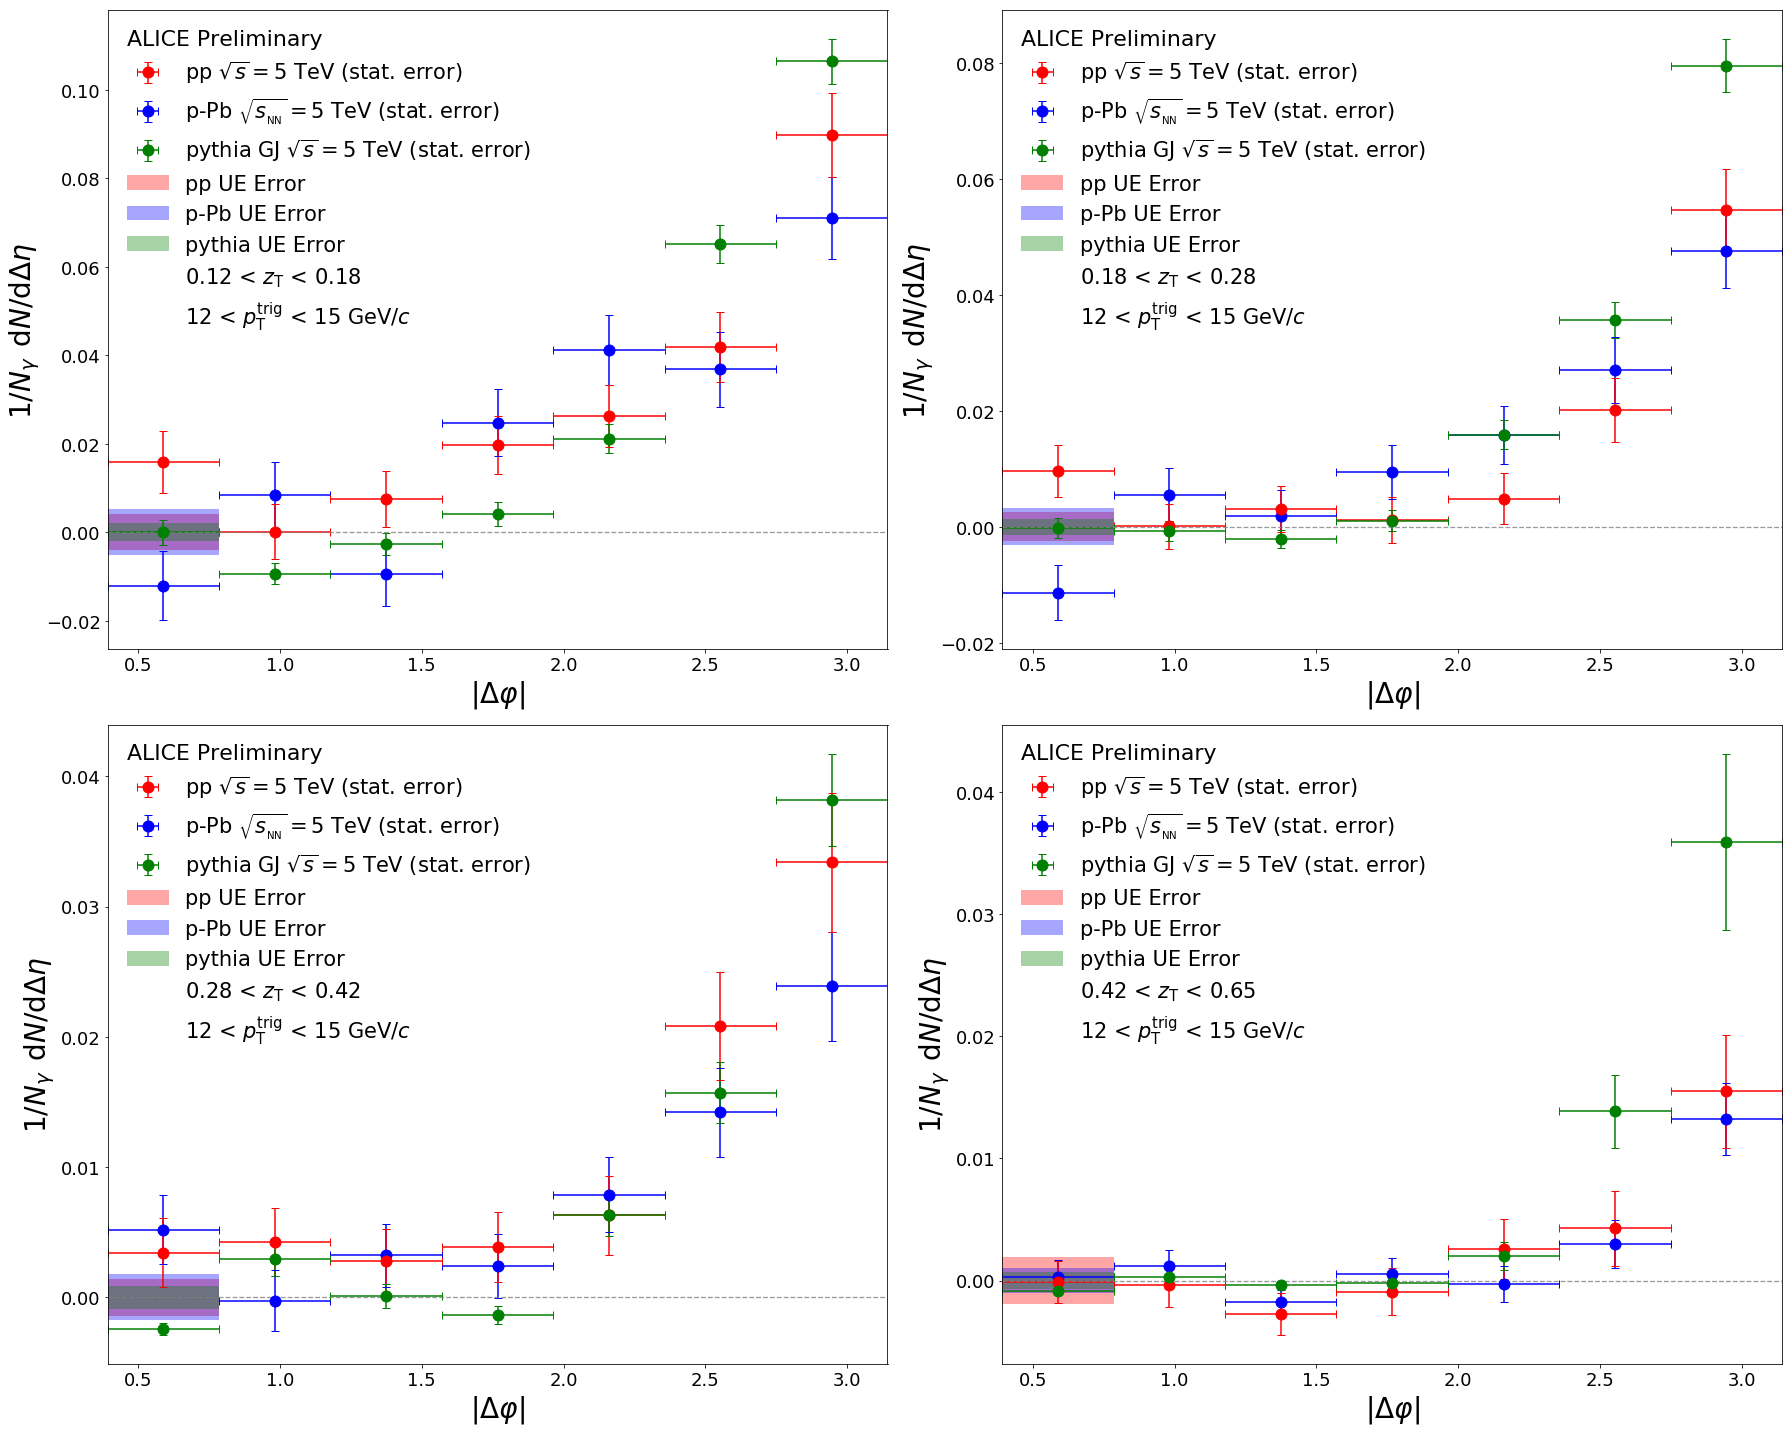

In [20]:
for ipt in range (3):
    if (ipt > 0): continue
    ipt = ipt+2
    fig = plt.figure(figsize=(25,20))
    for izt in range (zT_offset,NzT+zT_offset):
        ztb = izt-zT_offset

        if (NzT ==4):
            ax = fig.add_subplot(2,2,ztb+1)
        elif (NzT ==6):
            ax = fig.add_subplot(2,3,ztb+1)

        pPb = plt.errorbar(delta_phi_centers,pPb_CSR[ztb],xerr=phi_width,yerr=pPb_CSR_Errors[ztb],fmt='bo',capsize=4,markersize=11)
        pp = plt.errorbar(delta_phi_centers,pp_CSR[ztb],xerr=phi_width,yerr=pp_CSR_Errors[ztb],fmt='ro',capsize=4,markersize=11)
        
        if(Use_MC):
            MC = plt.errorbar(delta_phi_centers,MC_CSR[ztb],xerr=phi_width,yerr=MC_CSR_Errors[ztb],fmt='go',capsize=4,markersize=11)



        plt.xlabel(r'|$\Delta \varphi$|',fontsize=28)
        plt.xticks(fontsize=18)
        plt.xlim((0.39269908169872414,3.14159))
        plt.ylabel(r'$1/N_{\gamma} \: \: \mathrm{d}N/\mathrm{d}\Delta \eta$',fontsize=28)
        plt.yticks(fontsize=18)
        plt.axhline(y=0,color='gray',linestyle='--',linewidth=1.3,alpha=0.8)        
        
        pp_UE = ax.fill_between(ue_error_bar,-pp_LE_Error[ztb],pp_LE_Error[ztb],facecolor='red',alpha=0.35) #Other for pp
        pPb_UE = ax.fill_between(ue_error_bar,-pPb_LE_Error[ztb],pPb_LE_Error[ztb],facecolor='blue',alpha=0.35)#One for p-Pb
        MC_UE = ax.fill_between(ue_error_bar,-MC_LE_Error[ztb],MC_LE_Error[ztb],facecolor='green',alpha=0.35)#One for p-Pb
        
        empt, = ax.plot([], [],' ')
        empt2, = ax.plot([],[],' ')
        
        if(Use_MC):
            leg = plt.legend([pp,pPb,MC,pp_UE,pPb_UE,MC_UE,empt,empt2],['pp $\sqrt{s}= 5$ TeV (stat. error)',
                'p-Pb $\sqrt{s_{\mathrm{_{NN}}}}=5$ TeV (stat. error)','pythia GJ $\sqrt{s}=5$ TeV (stat. error)', 
                'pp UE Error', 'p-Pb UE Error','pythia UE Error', r'%1.2f < $z_\mathrm{T}$ < %1.2f'%(zTbins[izt],zTbins[izt+1]),
                r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1])],loc = "upper left",fontsize=21,frameon=False,numpoints=1)
        else:    
            leg = plt.legend([pp,pPb,pp_UE,pPb_UE,empt,empt2],['pp $\sqrt{s}= 5$ TeV (stat. error)',
                'p-Pb $\sqrt{s_{\mathrm{_{NN}}}}=5$ TeV (stat. error)', 'pp UE Error', 'p-Pb UE Error',
                r'%1.2f < $z_\mathrm{T}$ < %1.2f'%(zTbins[izt],zTbins[izt+1]),
                r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1])],loc = "upper left",fontsize=21,frameon=False,numpoints=1)
       
        leg.set_title("ALICE Preliminary")
        leg._legend_box.align = "left"
        plt.setp(leg.get_title(),fontsize=22)
        fig.tight_layout()
        
    plt.show()
    #fig.savefig('pics/Gamma_hadron_corr_zT_%i.pdf'%(ztb))
    fig.savefig('pics/Gamma_hadron_corr.pdf')

### Systamitic Errors (Boxes = Type B)

# Fragmentation Function

In [35]:
def Integrate_Away_Side(Phi_array,Phi_Errors):
    
    Low_Phi_Bin = 3 #Corresponds to ∆phi > 2.1
    FF_zt = np.zeros(NzT)
    FF_zt_Errors = np.zeros(NzT)
    for izt in range(zT_offset,NzT+zT_offset):
        ztb = izt-zT_offset
        zT_width = zTbins[izt+1]-zTbins[izt]
        
        temp_phi = Phi_array[ztb][(len(Phi_Errors[ztb])-Low_Phi_Bin):len(Phi_array[ztb])]
        FF_zt[ztb] = temp_phi.sum()/zT_width
        
        temp_error = (Phi_Errors[ztb][(len(Phi_Errors[ztb])-Low_Phi_Bin):len(Phi_Errors[ztb])])**2
        FF_zt_Errors[ztb] = math.sqrt(temp_error.sum())/zT_width
    return FF_zt, FF_zt_Errors 

In [36]:
pp_FF, pp_FF_Errors = Integrate_Away_Side(pp_CSR,pp_CSR_Errors)
pPb_FF, pPb_FF_Errors = Integrate_Away_Side(pPb_CSR,pPb_CSR_Errors)
MC_FF, MC_FF_Errors = Integrate_Away_Side(MC_CSR,MC_CSR_Errors)

## Error Handling

In [40]:
# Shower shape difference as systematic error is depricated
pp_E_Shower = np.array([0.33,0.10,0.06,0.01])
pPb_E_Shower = np.array([0.05,0.04,0.005,0.01])

pp_sys = np.zeros(NzT)
pPb_sys = np.zeros(NzT)
#If these remain 0, don't show up as boxes

if (CorrectedP): #This bool basically refers to reproducing Hard Probes 2018 plot
    pp_sys = np.sqrt(pp_E_Shower**2 + pp_LE_Error**2)
    pPb_sys = np.sqrt(pPb_E_Shower**2 + pPb_LE_Error**2)


In [37]:
pp_FF_Errors = np.sqrt(pp_FF_Errors**2 + pp_LE_Error**2)
pPb_FF_Errors = np.sqrt(pPb_FF_Errors**2 + pPb_LE_Error**2)
MC_FF_Errors = np.sqrt(MC_FF_Errors**2 + MC_LE_Error**2)

### Average the shower shapes:

In [38]:
SS_Average = False

if(SS_Average):
    NN_pp_FF = np.array([3.09208038, 4.06060791, 2.55636073, 0.754966, 0.40668246, 0.0860855])
    #NN_pp_FF[1.83783856,0.58949897,0.36403998,0.08016944]
    
    NN_pp_Error = np.array([1.00712306, 0.57571265, 0.30321927, 0.13821373, 0.06743482, 0.03615615])

    NN_pPb_FF = np.array([12.39342794, 7.37547956, 2.3925692, 0.91057808, 0.29133396, 0.0532953])
    NN_pPb_Error = np.array([1.19737744, 0.6651166, 0.31978294, 0.13846122, 0.05565065, 0.02261034])

    L0_pp_FF = np.array([3.57247865, 4.33031726, 2.9509478, 0.89608728, 0.48205601, 0.09990165])
    L0_pp_Error = np.array([1.18174165, 0.67436161, 0.35620501, 0.16348465, 0.08015733, 0.04290393])

    L0_pPb_FF = np.array([14.07293846, 7.08445849, 2.43431645, 0.97443936, 0.28721994, 0.04481062])
    L0_pPb_Error = np.array([1.36978768, 0.75748083, 0.36519239, 0.15894631, 0.06347339, 0.02589638])

    #Average
    Avg_pp_FF = (NN_pp_FF+L0_pp_FF)/2
    Avg_pPb_FF = (NN_pPb_FF+L0_pPb_FF)/2
    
    pp_FF = Avg_pp_FF[zT_offset:NzT+zT_offset]
    pPb_FF = Avg_pPb_FF[zT_offset:NzT+zT_offset]
    
    print(pp_FF)
    print(pPb_FF)



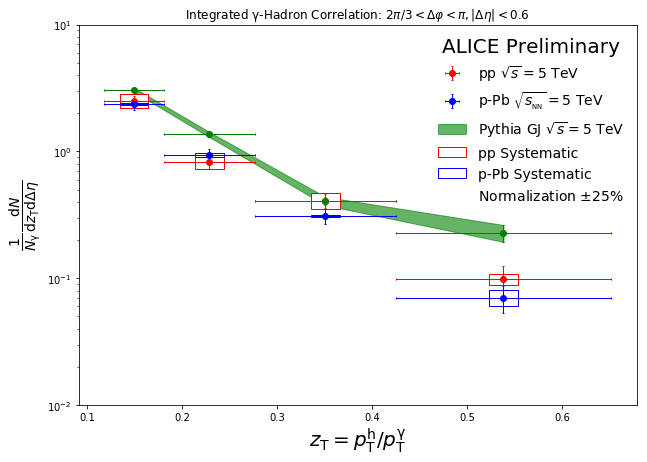

In [39]:
plt.figure(figsize=(10,7))

zt_box = np.ones(NzT) * 0.03
ey = np.asarray(pPb_sys)

pp_bar = plt.bar(zT_centers, pp_sys+pp_sys, bottom=pp_FF-pp_sys, width=zt_box, align='center',edgecolor="red",color='white',)
pPb_bar = plt.bar(zT_centers, pPb_sys+pPb_sys, bottom=pPb_FF-pPb_sys, width=zt_box, align='center',edgecolor="blue",color='white',)

pp_plot = plt.errorbar(zT_centers, pp_FF,xerr=zT_widths,yerr=pp_FF_Errors,linewidth=1,fmt='ro',capsize=1,label='pp')
pPb_plot = plt.errorbar(zT_centers, pPb_FF,xerr=zT_widths,yerr=pPb_FF_Errors,linewidth=1, fmt='bo',capsize=1,label='p-Pb')
if(Use_MC):
    plt.errorbar(zT_centers, MC_FF,xerr=zT_widths,yerr=MC_FF_Errors,linewidth=1, fmt='go',capsize=1,label='MC')
    MC_plot = plt.fill_between(zT_centers, MC_FF-MC_FF_Errors, MC_FF+MC_FF_Errors,color='green',alpha=0.6)

empt, = ax.plot([], [],' ')

plt.yscale('log')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
plt.ylabel(r"$\frac{1}{N_{\mathrm{\gamma}}}\frac{\mathrm{d}N}{\mathrm{d}z_{\mathrm{T}} \mathrm{d}\Delta\eta}$",fontsize=20)
plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^\mathrm{h}/p_\mathrm{T}^\mathrm{\gamma}$",fontsize=20)
#plt.xlim(xmin = 0.1,xmax=0.7)
plt.ylim(ymin = 0.01,ymax=10)

if(Use_MC):
    leg = plt.legend([pp_plot,pPb_plot,MC_plot,pp_bar,pPb_bar,empt],["pp $\sqrt{s} = 5$ TeV","p-Pb $\sqrt{s_{\mathrm{_{NN}}}}=5$ TeV","Pythia GJ $\sqrt{s} = 5$ TeV",
        "pp Systematic","p-Pb Systematic","Normalization $\pm 25\%$"],frameon=False,numpoints=1,title=' ',loc="upper right",prop={'size':14})
else:
    leg = plt.legend([pp_plot,pPb_plot,pp_bar,pPb_bar,empt],["pp $\sqrt{s} = 5$ TeV","p-Pb $\sqrt{s_{\mathrm{_{NN}}}}=5$ TeV",
        "pp Systematic","p-Pb Systematic","Normalization $\pm 25\%$"],frameon=False,numpoints=1,title=' ',loc="upper right",prop={'size':14})

leg.set_title("ALICE Preliminary")
plt.setp(leg.get_title(),fontsize=20)

plt.title(r'Integrated $\mathrm{\gamma}$-Hadron Correlation: $2\pi/3 < \Delta\varphi < \pi, |\Delta\eta| < %1.1f$ '%(eta_max))
plt.gcf()
plt.savefig("pics/All_FFunction.pdf", bbox_inches='tight')
plt.show()

## p-Pb/pp Ratio

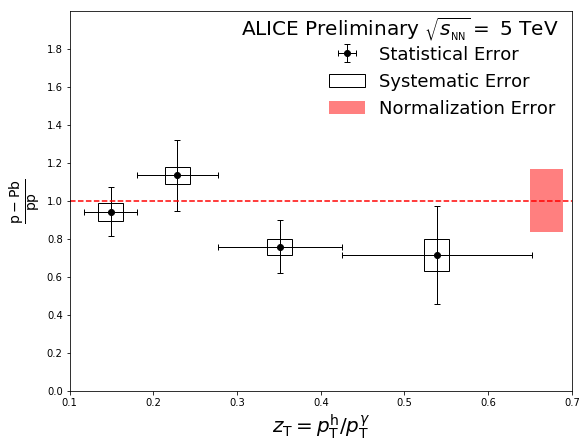

In [33]:
plt.figure(figsize=(9,7))


E_Shower_Ratio = np.array([0.05,0.04,0.055,0.115])

Ratio = pPb_FF/pp_FF

Ratio_Error = np.sqrt((pPb_FF_Errors/pPb_FF)**2 + (pp_FF_Errors/pp_FF)**2)*Ratio

Ratio_Systematic = np.sqrt((pp_LE_Error/pp_FF)**2 + (pPb_LE_Error/pPb_FF)**2 + E_Shower_Ratio**2)*Ratio

Sys_Plot = plt.bar(zT_centers, Ratio_Systematic+Ratio_Systematic, bottom=Ratio-Ratio_Systematic, width=zt_box, align='center',edgecolor="black",color='white',)

Sys_Box = [0.65,0.69]
xfill = [0.65,0.7]
Norm_Box = plt.fill_between(Sys_Box, 1-0.166, 1.166, where=xfill,interpolate=False, alpha=0.5,facecolor='red')

Ratio_Plot = plt.errorbar(zT_centers, Ratio, yerr=Ratio_Error,xerr=zT_widths, fmt='ko',capsize=3, ms=6,lw=1)
plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^{\mathrm{h}}/p_\mathrm{T}^\gamma$",fontsize=20)
plt.ylabel(r"$\frac{\mathrm{p-Pb}}{\mathrm{pp}}$",fontsize=20)
plt.ylim((0, 2))
plt.yticks(np.arange(-0, 2, step=0.2))
plt.xlim(xmin = 0.1,xmax=0.7)
plt.axhline(y=1, color='r', linestyle='--')

plt.legend([Ratio_Plot,Sys_Plot,Norm_Box],["Statistical Error","Systematic Error","Normalization Error"],frameon=False,numpoints=1,title=' ',prop={'size':18})
plt.figtext(0.39,0.83,"ALICE Preliminary $\sqrt{s_{\mathrm{_{NN}}}} = $ 5 TeV",color='Black', fontsize=20)

plt.gcf()
plt.savefig("pics/NN_pp_FFunction.pdf", bbox_inches='tight')
plt.show()

### Compare Low and High pT pPb

In [ ]:
High_pT_pPb_FF = [2.03221649, 0.71736468, 0.28149866, 0.07402162]
High_pT_pPb_FF_Errors = [0.23587166, 0.10777863, 0.06652155, 0.03262993]

Low_pT_pPb_FF = [1.67642229, 0.61790121, 0.26444223, 0.04028126]
Low_pT_pPb_FF_Errors = [0.2731475, 0.11976418, 0.04885695, 0.02073224]

In [ ]:
plt.figure(figsize=(10,7))

zt_box = np.ones(NzT) * 0.03
ey = np.asarray(pPb_sys)

zT_centers_off = zT_centers + 0.01
Low_pT_plot = plt.errorbar(zT_centers, Low_pT_pPb_FF,xerr=zT_widths,yerr=Low_pT_pPb_FF_Errors,linewidth=1, fmt='bo',capsize=1,label='p-Pb')
High_pT_plot = plt.errorbar(zT_centers_off, High_pT_pPb_FF,xerr=zT_widths,yerr=High_pT_pPb_FF_Errors,linewidth=1,fmt='ro',capsize=1,label='pp')

empt, = ax.plot([], [],' ')

plt.yscale('log')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
plt.ylabel(r"$\frac{1}{N_{\mathrm{\gamma}}}\frac{\mathrm{d}N}{\mathrm{d}z_{\mathrm{T}} \mathrm{d}\Delta\eta}$",fontsize=20)
plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^\mathrm{h}/p_\mathrm{T}^\mathrm{\gamma}$",fontsize=20)
#plt.xlim(xmin = 0.1,xmax=0.7)
plt.ylim(ymin = 0.01,ymax=10)

leg = plt.legend([High_pT_plot,Low_pT_plot],["p-Pb $15 <p_\mathrm{T}^{Clus.} < 20$ GeV","p-Pb $12 <p_\mathrm{T}^{Clus.} < 15$ GeV"]
                 ,frameon=False,numpoints=1,title=' ',loc="upper right",prop={'size':15})
#leg.set_title("ALICE Preliminary")
#plt.setp(leg.get_title(),fontsize=20)

plt.title(r'Integrated $\mathrm{\gamma}$-Hadron Correlation: $2\pi/3 < \Delta\varphi < \pi, |\Delta\eta| < %1.1f$ '%(eta_max))
plt.gcf()
plt.savefig("pics/All_FFunction.pdf", bbox_inches='tight')
plt.show()

## Compare to Alwina's pythia:

In [ ]:
AL_MC_FF = np.array([4.31955339009877, 4.221120762569847, 3.8513237598133423, 2.6958245155997327])
AL_MC_FF_Errors =  np.array([0.20744562679073691, 0.2152168981595775, 0.2379945692723888, 0.24741289559999502])
plt.figure(figsize=(10,7))

zt_box = np.ones(NzT) * 0.03
ey = np.asarray(pPb_sys)

pp_bar = plt.bar(zT_centers, pp_sys+pp_sys, bottom=pp_FF-pp_sys, width=zt_box, align='center',edgecolor="red",color='white',)
pPb_bar = plt.bar(zT_centers, pPb_sys+pPb_sys, bottom=pPb_FF-pPb_sys, width=zt_box, align='center',edgecolor="blue",color='white',)

pp_plot = plt.errorbar(zT_centers, pp_FF,xerr=zT_widths,yerr=pp_FF_Errors,linewidth=1,fmt='ro',capsize=1,label='pp')
pPb_plot = plt.errorbar(zT_centers, pPb_FF,xerr=zT_widths,yerr=pPb_FF_Errors,linewidth=1, fmt='bo',capsize=1,label='p-Pb')

plt.errorbar(zT_centers, AL_MC_FF,xerr=zT_widths,yerr=AL_MC_FF_Errors,linewidth=1, fmt='go',capsize=1,label='MC')
MC_plot = plt.fill_between(zT_centers, AL_MC_FF-AL_MC_FF_Errors, AL_MC_FF+AL_MC_FF_Errors,color='green',alpha=0.6)

empt, = ax.plot([], [],' ')

plt.yscale('log')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
plt.ylabel(r"$\frac{1}{N_{\mathrm{\gamma}}}\frac{\mathrm{d}N}{\mathrm{d}z_{\mathrm{T}} \mathrm{d}\Delta\eta}$",fontsize=20)
plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^\mathrm{h}/p_\mathrm{T}^\mathrm{\gamma}$",fontsize=20)
#plt.xlim(xmin = 0.1,xmax=0.7)
plt.ylim(ymin = 0.01,ymax=10)

if(Use_MC):
    leg = plt.legend([pp_plot,pPb_plot,MC_plot,pp_bar,pPb_bar,empt],["pp $\sqrt{s} = 5$ TeV","p-Pb $\sqrt{s_{\mathrm{_{NN}}}}=5$ TeV","Pythia GJ $\sqrt{s} = 5$ TeV",
        "pp Systematic","p-Pb Systematic","Normalization $\pm 25\%$"],frameon=False,numpoints=1,title=' ',loc="best",prop={'size':12})

leg.set_title("ALICE Preliminary")
plt.setp(leg.get_title(),fontsize=20)

plt.title(r'Integrated $\mathrm{\gamma}$-Hadron Correlation: $2\pi/3 < \Delta\varphi < \pi, |\Delta\eta| < %1.1f$ '%(eta_max))
plt.gcf()
plt.savefig("pics/All_FFunction.pdf", bbox_inches='tight')
plt.show()


## Jet Fragmentation Comparison

In [ ]:
##### Digitized by Fernando from paper #####
jet_5_10_x = np.array([0.077,0.127,0.176,0.226,0.276,0.326,0.375,0.425,0.476,0.525,0.575,0.626,0.675,0.725,0.776,0.826,0.925])
jet_5_10_y = np.array([14.365,12.023,9.813,7.862,6.243,4.979,4.045,3.260,2.598,2.072,1.677,1.320,1.048,0.842,0.680,0.549,0.377])

jet_10_15_x = np.array([0.077,0.127,0.176,0.226,0.276,0.326,0.375,0.476,0.525,0.575,0.626,0.675,0.725,0.776,0.826,0.875,0.925])
jet_10_15_y = np.array([23.185,17.108,12.583,9.358,6.987,5.213,3.956,2.233,1.637,1.304,1.007,0.774,0.597,0.454,0.370,0.284,0.219])

jet_5_10_y = jet_5_10_y*(1.0/6)
jet_10_15_y = jet_10_15_y*(1.0/6)

jet_5_10_x = jet_5_10_x*(2.0/3.0)
jet_10_15_x = jet_10_15_x*(2.0/3.0)

In [ ]:
plt.figure(figsize=(9,7))

jet1 = plt.errorbar(jet_5_10_x,jet_5_10_y,yerr=0,xerr=0.025,fmt='s',color='green',alpha=0.6,label=r'$p_T^{ch\ jet}$ 5-10GeV/c')
jet2 = plt.errorbar(jet_10_15_x,jet_10_15_y,yerr=0,xerr=0.025,fmt='cs',alpha=0.6,label=r'$p_T^{ch\ jet}$ 10-15GeV/c')

pp_bar = plt.bar(zT_centers, pp_sys+pp_sys, bottom=pp_FF-pp_sys, width=zt_box, align='center',edgecolor="red",color='white',)
pPb_bar = plt.bar(zT_centers, pPb_sys+pPb_sys, bottom=pPb_FF-pPb_sys, width=zt_box, align='center',edgecolor="blue",color='white',)

pp_plot = plt.errorbar(zT_centers, pp_FF,xerr=zT_widths,yerr=pp_FF_Errors,linewidth=1,fmt='ro',capsize=1,label='pp')
pPb_plot = plt.errorbar(zT_centers, pPb_FF,xerr=zT_widths,yerr=pPb_FF_Errors,linewidth=1, fmt='bo',capsize=1,label='p-Pb')

empt, = ax.plot([], [],' ')

plt.yscale('log')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
plt.ylabel(r"$\frac{1}{N_{\mathrm{\gamma}}}\frac{\mathrm{d}N}{\mathrm{d}z_{\mathrm{T}} \mathrm{d}\Delta\eta}$",fontsize=20)
plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^\mathrm{h}/p_\mathrm{T}^\mathrm{\gamma}$",fontsize=20)
#plt.xlim(xmin = 0.1,xmax=0.7)
#plt.ylim(ymin = 0.01,ymax=10)

leg = plt.legend([pp_plot,pPb_plot,jet1,jet2],["pp $\sqrt{s} = 5$ TeV","p-Pb $\sqrt{s_{\mathrm{_{NN}}}}=5$ TeV",
    r'$p_\mathrm{T}^{\mathrm{ch\ jet}}$ 5-10 $\mathrm{GeV}/c$',r'$p_\mathrm{T}^{\mathrm{ch\ jet}}$ 10-15 $\mathrm{GeV}/c$']
    ,frameon=False,numpoints=1,title=' ',loc="best",prop={'size':15})

#plt.legend([pp_plot,pPb_plot,jet1,jet2],["pp","p-Pb",r'$p_\mathrm{T}^{\mathrm{ch\ jet}}$ 5-10 $\mathrm{GeV}/c$',r'$p_\mathrm{T}^{\mathrm{ch\ jet}}$ 10-15 $\mathrm{GeV}/c$'],frameon=False,numpoints=1,title='',prop={'size':12})
leg.set_title("ALICE Preliminary")
plt.setp(leg.get_title(),fontsize=20)

plt.title(r'Integrated $\mathrm{\gamma}$-Hadron Correlation: $2\pi/3 < \Delta\varphi < \pi, |\Delta\eta| < %1.1f$ '%(eta_max))
plt.gcf()
plt.savefig("pics/All_FFunction.pdf", bbox_inches='tight')
plt.show()

# Gustavo pp 7 TeV Comparison

In [ ]:
file = ROOT.TFile("InputData/pp7TeV.root")
#file.ls()
pp7 = file.Get("h_xEphotonTot")
pp7_sys = file.Get("Syst")

plot = False
if (plot):
    c = ROOT.TCanvas("c","c",2000,1000)
    pp7.Draw()
    pp7_sys.SetFillColor(0)
    ROOT.gPad.SetLogy()
    pp7_sys.SetLineColor(1)
    pp7_sys.Draw("sameE2")
    c.Draw()
    
nbins = pp7.GetSize()-2 
pp7_data = np.zeros(nbins)
pp7_x = np.zeros(nbins)
pp7_error = np.zeros(nbins)
pp7_width = np.zeros(nbins)
pp7_Sys = np.zeros(nbins)

for i in range (1,nbins+1):
    pp7_data[i-1] = pp7.GetBinContent(i)
    pp7_x[i-1] = pp7.GetBinCenter(i)
    pp7_error[i-1] = pp7.GetBinError(i)
    pp7_width[i-1] = pp7.GetXaxis().GetBinWidth(i)/2
    pp7_Sys[i-1] = pp7_sys.GetBinError(i)


In [ ]:
plt.figure(figsize=(10,7))

zt_box = np.ones(NzT) * 0.03
ey = np.asarray(pPb_sys)



pp7_bar = plt.bar(pp7_x,pp7_Sys+pp7_Sys, bottom = pp7_data-pp7_Sys, width = 0.03,align='center',edgecolor='green',color='white')
pp_bar = plt.bar(zT_centers, pp_sys+pp_sys, bottom=pp_FF-pp_sys, width=zt_box, align='center',edgecolor="red",color='white')
#pPb_bar = plt.bar(zT_centers, pPb_sys+pPb_sys, bottom=pPb_FF-pPb_sys, width=zt_box, align='center',edgecolor="blue",color='white')

pp7_plot = plt.errorbar(pp7_x,pp7_data,xerr = pp7_width,yerr= pp7_error,linewidth=1,fmt = 'go',capsize=1,label = 'pp7')
pp_plot = plt.errorbar(zT_centers, pp_FF,xerr=zT_widths,yerr=pp_FF_Errors,linewidth=1,fmt='ro',capsize=1,label='pp')
#pPb_plot = plt.errorbar(zT_centers, pPb_FF,xerr=zT_widths,yerr=pPb_FF_Errors,linewidth=1, fmt='bo',capsize=1,label='p-Pb')

empt, = ax.plot([], [],' ')

plt.yscale('log')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
plt.ylabel(r"$\frac{1}{N_{\mathrm{\gamma}}}\frac{\mathrm{d}N}{\mathrm{d}z_{\mathrm{T}} \mathrm{d}\Delta\eta}$",fontsize=20)
plt.xlabel("${z_\mathrm{T}} = p_\mathrm{T}^\mathrm{h}/p_\mathrm{T}^\mathrm{\gamma}$",fontsize=20)
plt.xlim(xmin = 0.1,xmax=0.7)

leg = plt.legend([pp_plot,pp7_plot],["pp $\sqrt{s} = 5$ TeV","pp $\sqrt{s} = 7$ TeV"]
    ,frameon=False,numpoints=1,title=' ',loc="upper right",prop={'size':15})
leg.set_title("ALICE Preliminary")
plt.setp(leg.get_title(),fontsize=20)

plt.title(r'Integrated $\mathrm{\gamma}$-Hadron Correlation: $2\pi/3 < \Delta\varphi < \pi, |\Delta\eta| < 0.6$ ')
plt.gcf()
plt.savefig("pics/All_FFunction.pdf", bbox_inches='tight')
plt.show()

# Review Triggers

In [ ]:
NTRig_pp_NN = Get_NTriggers('InputData/17q_SE_NN_Correlation_GMB_Ratio.root',2,True)
NTRig_pp_LO = Get_NTriggers('InputData/17q_SE_L0_Correlation_GMB_Ratio.root',2,True)
NTRig_pPb_NN = Get_NTriggers('InputData/13def_SE_GMB_new_Ratio.root',2,True)
NTRig_pPb_LO = Get_NTriggers('InputData/13def_SE_L0_Correlation_GMB_Ratio.root',2,True)

In [ ]:
from IPython.display import Markdown as md

In [ ]:
print("|       -        | pp NN   | pp $\lambda_{0}$ | pPb NN| pPb $\lambda_{0}$ |")
print("| ------------- |:-------:| ------:|:-----:|:-------:|")
print("| Triggers  |  %1.f  |  %1.f | %1.f |  %1.f  |"%(NTRig_pp_NN,NTRig_pp_LO,NTRig_pPb_NN,NTRig_pPb_LO))

|     Cluster $p_{\mathrm{T}}$ | pp NN  | pp $\lambda_{0}$ | pp Both| pPb NN| pPb $\lambda_{0}$ | pPb Both |
| ---------- |:-------:|:-----:|:-----:|:-----:|:-----:|:---:|
| 12-15 GeV  |  14128  | 14500 | 11707 | 24529 | 26284 |21170|
| 15-20 GeV  |  6668   | 7165  | 5380  | 11429 | 12940 |9443 |
| 20-40 GeV  |  2805   | 3513  | 2196  | 5237  | 6961  |4300|
| 15-40 GeV  |  9473   | 10678 | 7576  | 16666 | 19901 |13743|

# Fragmentation Function

## FIXME: Fit pPb

In [ ]:
z_error = [0,0,0,0,0,0]
pPb_Fit_Plot = ROOT.TGraphErrors()#(6,np.asarray(zT_point),np.asarray(pPb_int),np.asarray(z_error),np.asarray(pPb_error)))
latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.05)

for i in range (4):
    izt = i
    pPb_Fit_Plot.SetPoint(i,zT_point[izt],pPb_int[izt])
    pPb_Fit_Plot.SetPointError(i,0,pPb_error[izt])
pPb_Fit_Plot.Fit("expo")

pPb_canv = ROOT.TCanvas("pPbcan","pPbcan",500,500)
pPb_Fit_Plot.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
pPb_Fit_Plot.GetXaxis().SetTitle("z_{T}")
pPb_Fit_Plot.GetXaxis().CenterTitle(1)
pPb_Fit_Plot.GetYaxis().CenterTitle(1)
pPb_Fit_Plot.Draw("AP")
latex.DrawLatex(0.78,0.85, "#color[4]{pPb}")
latex.SetTextSize(0.04)
latex.DrawLatex(0.55,0.79, "#color[4]{Slope = -9.9 #pm 0.8}")
ROOT.gPad.SetLogy()
pPb_canv.Update()
pPb_canv.Draw()
pPb_canv.SaveAs("pics/pPb_FF_Fit.pdf")
#         for NBin in range(0,NBins+1):
#         ZYAM.SetPoint(NBin,(NBin*math.pi/NBins),zyam_value)
#         ZYAM.SetPointError(NBin,0,Z_Error)

## Fit pp

In [ ]:
pp_Fit_Plot = ROOT.TGraphErrors()#(

latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.05)
print zT_point
for i in range (4):
    izt = i
    pp_Fit_Plot.SetPoint(i,zT_point[izt],pp_int[izt])
    pp_Fit_Plot.SetPointError(i,0,pp_error[izt])
pp_Fit_Plot.Fit("expo")

pp_canv = ROOT.TCanvas("ppcan","ppcan",500,500)
pp_Fit_Plot.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
pp_Fit_Plot.GetXaxis().SetTitle("z_{T}")
pp_Fit_Plot.GetXaxis().CenterTitle(1)
pp_Fit_Plot.GetYaxis().CenterTitle(1)
pp_Fit_Plot.Draw("AP")
latex.DrawLatex(0.81,0.85, "#color[4]{pp}")
latex.SetTextSize(0.04)
latex.DrawLatex(0.55,0.79, "#color[4]{Slope = -8.3 #pm 0.8}")
ROOT.gPad.SetLogy()
pp_canv.Update()
pp_canv.Draw()
pp_canv.SaveAs("pics/pp_FF_Fit.pdf")
pp_Fit_Plot = ROOT.TGraphErrors()

# Fit Jets

In [ ]:
z_error = [0,0,0,0,0,0]
pPb_Fit_Plot = ROOT.TGraphErrors()
pPb_Fit_Plot2 = ROOT.TGraphErrors()
latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.05)

for i in range (17):
    izt = i
    pPb_Fit_Plot.SetPoint(i,jet_10_15_x[i],jet_10_15_y[i])
    pPb_Fit_Plot2.SetPoint(i,jet_5_10_x[i],jet_5_10_y[i])
    #pPb_Fit_Plot.SetPointError(i,0,pPb_error[izt])
pPb_Fit_Plot.Fit("expo")
pPb_Fit_Plot2.Fit("expo")

pPb_canv2 = ROOT.TCanvas("pPbcan2","pPbcan2",1000,500)
pPb_canv2.Divide(2,1)
pPb_canv2.cd(1)
ROOT.gPad.SetLogy()
pPb_Fit_Plot.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
pPb_Fit_Plot.GetXaxis().SetTitle("z_{T}")
pPb_Fit_Plot.GetXaxis().CenterTitle(1)
pPb_Fit_Plot.GetYaxis().CenterTitle(1)
pPb_Fit_Plot.Draw("AP")
#pPb_Fit_Plot.GetXaxis().SetRangeUser(0,1)
#pPb_Fit_Plot.GetYaxis().SetRangeUser(0.01,20)
latex.DrawLatex(0.5,0.85, "#color[4]{10-15 GeV Jets}")
latex.SetTextSize(0.04)
latex.DrawLatex(0.55,0.79, "#color[4]{Slope = -9 #pm 0.06}")



pPb_canv2.cd(2)
pPb_Fit_Plot2.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
pPb_Fit_Plot2.GetXaxis().SetTitle("z_{T}")
pPb_Fit_Plot2.GetXaxis().CenterTitle(1)
pPb_Fit_Plot2.GetYaxis().CenterTitle(1)
pPb_Fit_Plot2.Draw("AP")
latex.DrawLatex(0.6,0.85, "#color[4]{5-10 GeV Jets}")
latex.SetTextSize(0.04)
latex.DrawLatex(0.55,0.79, "#color[4]{Slope = -6.4 #pm 0.07}")



ROOT.gPad.SetLogy()
pPb_canv2.Update()
pPb_canv2.Draw()
pPb_canv2.SaveAs("pics/Jet_FF_Fit.pdf")
#         for NBin in range(0,NBins+1):
#         ZYAM.SetPoint(NBin,(NBin*math.pi/NBins),zyam_value)
#         ZYAM.SetPointError(NBin,0,Z_Error)

# Divide FF

# Fit Ratio

In [ ]:
Ratio_Plot = ROOT.TGraphErrors()

deg = 0

latex = TLatex()
latex.SetNDC()
latex.SetTextSize(0.05)
print zT_point
for i in range (4):
    izt = i
    Ratio_Plot.SetPoint(i,zT_point[izt],Ratio[izt])
    Ratio_Plot.SetPointError(i,0,Ratio_Error[izt])
Ratio_Plot.Fit("pol%i"%(deg))
Ratio_Plot.GetFunction("pol%i"%(deg)).SetLineColor(9);

Ratio_canv = ROOT.TCanvas("rcan","rcan",500,500)
Ratio_Plot.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{dN}{dZ_{T}}")
Ratio_Plot.GetXaxis().SetTitle("z_{T}")
Ratio_Plot.GetXaxis().CenterTitle(1)
Ratio_Plot.GetYaxis().CenterTitle(1)
Ratio_Plot.GetYaxis().SetRangeUser(0,2)
Ratio_Plot.Draw("AP")
latex.DrawLatex(0.15,0.85, "#color[4]{pPb/pp}")
latex.DrawLatex(0.15,0.80, "#color[9]{Pol%i Fit}"%(deg))
if (deg == 1):
    latex.DrawLatex(0.65,0.75, "#chi^{2}_{red} = 0.8")
    latex.DrawLatex(0.6,0.85,"p0 = 1.1 #pm 0.2")
    latex.DrawLatex(0.6,0.80,"p1 = -1.0 #pm 0.7")
elif (deg ==0):
    latex.DrawLatex(0.65,0.8, "#chi^{2}_{red} = 1.1")
    latex.DrawLatex(0.55,0.85,"p0 = 0.85 #pm 0.09")

zero_line = ROOT.TLine(0.122,1,0.575,1)
zero_line.SetLineColorAlpha(1, 0.9)
zero_line.SetLineWidth(1)
zero_line.SetLineStyle(2)
SetOwnership(zero_line, 0)
zero_line.Draw("same")

latex.SetTextSize(0.04)
#ROOT.gPad.SetLogy()
Ratio_canv.Update()
Ratio_canv.Draw()
Ratio_canv.SaveAs("pics/Ratio_Fit_%i.pdf"%(deg))
pp_Fit_Plot = ROOT.TGraphErrors()

### Hardcoded difference in showers shape Lambda and NN

In [ ]:
# NN_pp_FF = np.array([3.09208038, 4.06060791, 2.55636073, 0.754966, 0.40668246, 0.0860855])
# NN_pp_Error = np.array([1.00712306, 0.57571265, 0.30321927, 0.13821373, 0.06743482, 0.03615615])

# NN_pPb_FF = np.array([12.39342794, 7.37547956, 2.3925692, 0.91057808, 0.29133396, 0.0532953])
# NN_pPb_Error = np.array([1.19737744, 0.6651166, 0.31978294, 0.13846122, 0.05565065, 0.02261034])

# L0_pp_FF = np.array([3.57247865, 4.33031726, 2.9509478, 0.89608728, 0.48205601, 0.09990165])
# L0_pp_Error = np.array([1.18174165, 0.67436161, 0.35620501, 0.16348465, 0.08015733, 0.04290393])

# L0_pPb_FF = np.array([14.07293846, 7.08445849, 2.43431645, 0.97443936, 0.28721994, 0.04481062])
# L0_pPb_Error = np.array([1.36978768, 0.75748083, 0.36519239, 0.15894631, 0.06347339, 0.02589638])

# Avg_pp_FF = (NN_pp_FF+L0_pp_FF)/2
# Avg_pp_Error = np.sqrt(NN_pp_FF**2+L0_pp_FF**2)/2
# Delta_pp_FF = (NN_pp_FF-L0_pp_FF)/(NN_pp_FF+L0_pp_FF) #Taking half the diff as 1 sigma

# Avg_pPb_FF = (NN_pPb_FF + L0_pp_FF)/2
# Avg_pPb_Error = np.sqrt(NN_pPb_FF**2+L0_pPb_FF**2)/2
# Delta_pPb_FF = (NN_pPb_FF - L0_pPb_FF)/(NN_pPb_FF + L0_pp_FF)